In [8]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import (
    DeciferDataset
)
from pytorch_metric_learning.losses import NTXentLoss 
from tqdm.auto import tqdm

dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq"])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
loss_function = NTXentLoss(temperature=0.01)

def augmentation(xrd, scale=0.01):
    return xrd + torch.randn_like(xrd) * scale 

# Model definitions
class CLEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CLEncoder, self).__init__()
        # Encoder head
        self.enc = nn.Linear(input_dim, 128)
        
        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, data, train=True):
        if train:
            # Get two augmentations of the same batch
            augm1 = augmentation(data)
            augm2 = augmentation(data)
        
            # Extract encoder embeddings
            h_1 = self.enc(augm1)
            h_2 = self.enc(augm2)
        else:
            # Extract encoder embeddings
            h = self.enc(data)
            return h

        # Extract low dim embeddings
        h_1_latent = self.proj(h_1)
        h_2_latent = self.proj(h_2)
        return h_1, h_2, h_1_latent, h_2_latent

# Initialize models
xrd_input_dim = 1000
embedding_dim = 12

xrd_encoder = CLEncoder(xrd_input_dim, embedding_dim)

# Optimizer and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Extract embeddings before training
xrd_encoder.eval()

# Training loop
num_epochs = 10                                        

# Training Loop
for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0

    for batch in tqdm(dataloader):
        xrd = batch[0].to(device)                    

        optimizer.zero_grad()

        # Forward pass
        h_1, h_2, h_1_latent, h_2_latent = xrd_encoder(xrd)
        
        # Prepare for loss
        embeddings = torch.cat((h_1_latent, h_2_latent))
        indices = torch.arange(0, h_1_latent.size(0), device=h_2_latent.device)
        labels = torch.cat((indices, indices))
        
        # Compute loss using the corrected nt_xent_loss
        loss = loss_function(embeddings, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xrd.size(0)

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get sample batch
sample = next(iter(dataloader))[0]

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
#labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], 
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca())

def sim_matrix(a, b, eps=1e-8):
    """
    Eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

# Select index
idx = 1
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")
plt.plot(sample[idx].cpu())
plt.plot(sample[similar_idx].cpu())
plt.show()

  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0992


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0526


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0420


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0332


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0292


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0314


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0262


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0301


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0235


  0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0239


NameError: name 'xrd_embeddings_before' is not defined

In [44]:
model = CLEncoder(xrd_input_dim, embedding_dim).to(device='cuda')

In [45]:
model.load_state_dict(xrd_encoder.state_dict())

<All keys matched successfully>

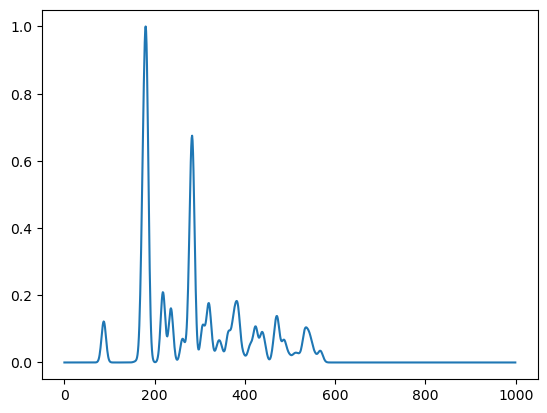

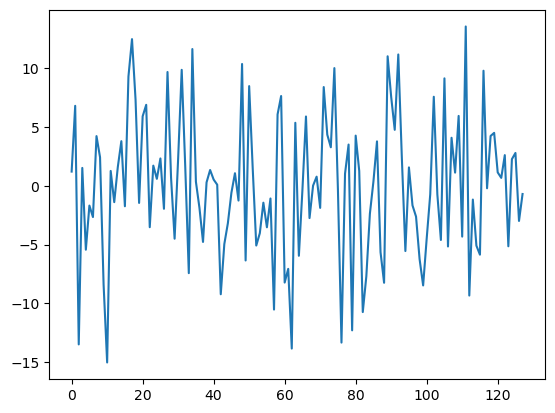

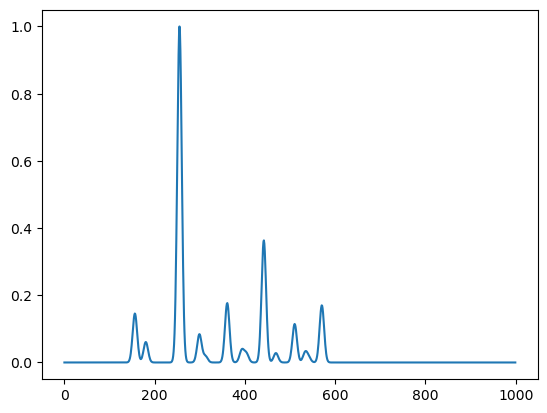

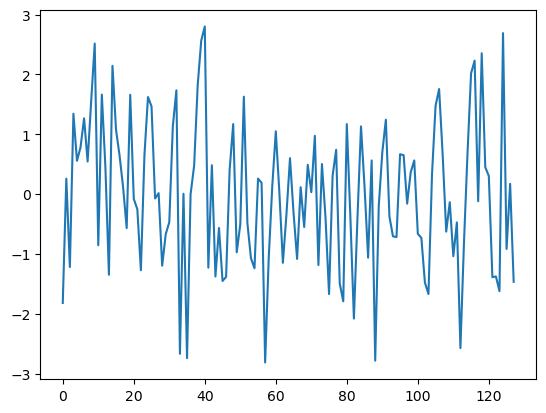

In [50]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(dataset):
        if i > 1:
            break
        xrd = data[0].to(device)
        h = model(xrd, train=False)
        plt.plot(xrd.cpu().numpy())
        plt.show()
        plt.plot(h.cpu().numpy())
        plt.show()

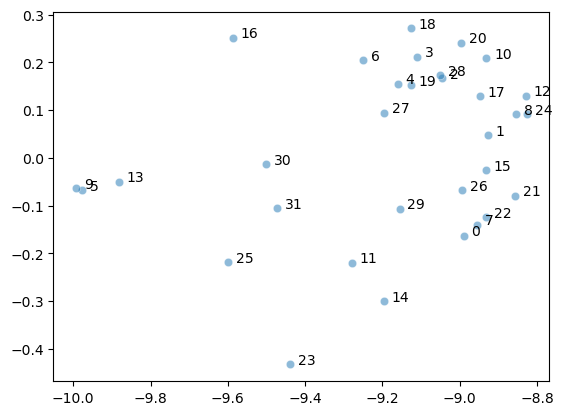

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Get sample batch
sample = next(iter(dataloader))[0]

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
#labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], 
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca())

Most similar data point in the embedding space for 1 is 7


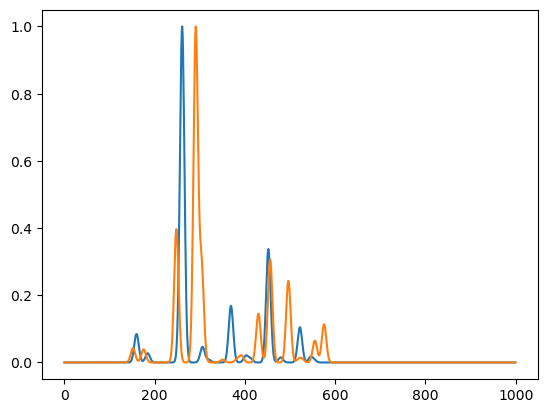

In [59]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get sample batch
sample = next(iter(dataloader))[0]

# Get representations
h = model(sample.to(device), train=False)
h = h.cpu().detach()
#labels = sample.category.cpu().detach().numpy()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], 
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca())

def sim_matrix(a, b, eps=1e-8):
    """
    Eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

# Select index
idx = 1
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")
plt.plot(sample[idx].cpu())
plt.plot(sample[similar_idx].cpu())
plt.show()

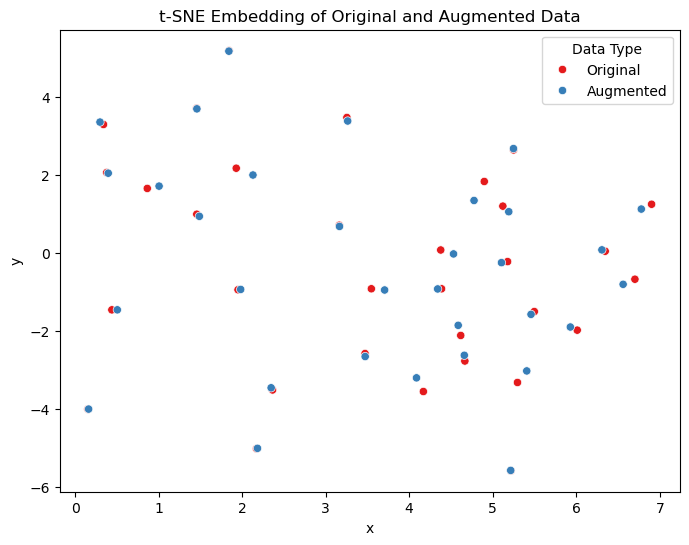

Most similar augmented data point for original sample 1 is augmented sample 1


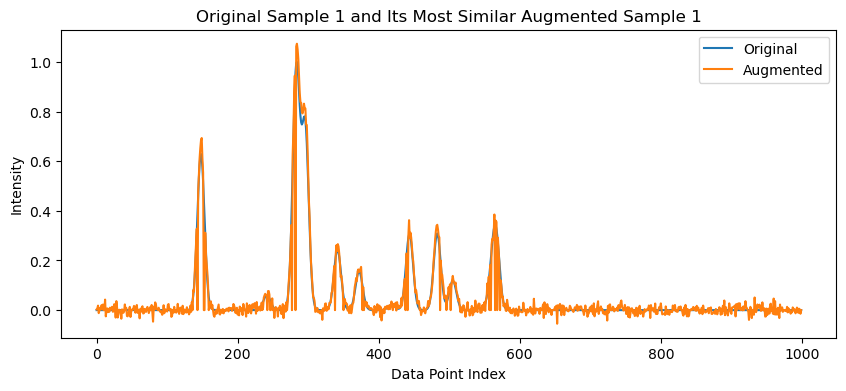

In [64]:
# Define a more complex augmentation function for XRD data
def augmentation(xrd, noise_scale=0.01, intensity_scale_range=(0.9, 1.1), background_scale=0.01, mask_prob=0.1):
    # Add Gaussian noise
    xrd_noisy = xrd + torch.randn_like(xrd) * noise_scale

    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd_noisy * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask

    return xrd_augmented

# Visualization
# Get a sample batch
sample = next(iter(dataloader))[0].to(device)

# Generate augmented samples
augmented_sample = augmentation(sample)

# Get representations
with torch.no_grad():
    h_original = model(sample, train=False).cpu()
    h_augmented = model(augmented_sample, train=False).cpu()

# Combine representations
h_combined = torch.cat([h_original, h_augmented], dim=0)

# Assign labels: 0 for original, 1 for augmented
labels = np.array(['Original']*h_original.size(0) + ['Augmented']*h_augmented.size(0))

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_combined.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({'x': h_embedded[:, 0], 'y': h_embedded[:, 1], 'label': labels})

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='label', data=df, palette="Set1")
plt.title('t-SNE Embedding of Original and Augmented Data')
plt.legend(title='Data Type')
plt.show()

# Similarity analysis
def sim_matrix(a, b, eps=1e-8):
    """
    Compute cosine similarity between two sets of embeddings
    """
    a_n = a.norm(dim=1)[:, None]
    b_n = b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

# Compute similarity between original and augmented embeddings
similarity = sim_matrix(h_original, h_augmented)

# For each sample, find the index of the most similar augmented sample
max_indices = similarity.argmax(dim=1)
max_vals = similarity.max(dim=1).values

# Select an index to analyze
idx = 1  # Change this index to analyze different samples
similar_idx = max_indices[idx]
print(f"Most similar augmented data point for original sample {idx} is augmented sample {similar_idx}")

# Plot the original and most similar augmented sample
plt.figure(figsize=(10, 4))
plt.plot(sample[idx].cpu().numpy(), label='Original')
plt.plot(augmented_sample[similar_idx].cpu().numpy(), label='Augmented')
plt.legend()
plt.title(f'Original Sample {idx} and Its Most Similar Augmented Sample {similar_idx}')
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.show()

In [9]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import DeciferDataset
from pytorch_metric_learning.losses import NTXentLoss
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd

# Define a more complex augmentation function for XRD data
def augmentation(xrd, intensity_scale_range=(0.9, 1.1), background_scale=0.05, mask_prob=0.1):

    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask
    
    # Clipping
    xrd_augmented[xrd_augmented < 0] = 0.0

    return xrd_augmented

# Model definitions
class CLEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CLEncoder, self).__init__()
        # Encoder head
        self.enc = nn.Linear(input_dim, 128)
        
        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, data, train=True):
        if train:
            # Get two augmentations of the same batch
            augm1 = augmentation(data)
            augm2 = augmentation(data)
        
            # Extract encoder embeddings
            h_1 = self.enc(augm1)
            h_2 = self.enc(augm2)

            # Extract low dim embeddings
            h_1_latent = self.proj(h_1)
            h_2_latent = self.proj(h_2)
            return h_1, h_2, h_1_latent, h_2_latent
        else:
            # Extract encoder embeddings
            h = self.enc(data)
            return h

# Initialize models
xrd_input_dim = 1000  # Adjust according to your data
embedding_dim = 12

xrd_encoder = CLEncoder(xrd_input_dim, embedding_dim)

# Optimizer and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Dataset and DataLoader
batch_size = 128
dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq"])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_function = NTXentLoss(temperature=0.07)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        xrd = batch[0].to(device)
        optimizer.zero_grad()

        # Forward pass
        h_1, h_2, h_1_latent, h_2_latent = xrd_encoder(xrd)
        
        # Prepare for loss
        embeddings = torch.cat((h_1_latent, h_2_latent), dim=0)
        indices = torch.arange(0, h_1_latent.size(0), device=h_2_latent.device)
        labels = torch.cat((indices, indices), dim=0)
        
        # Compute loss
        loss = loss_function(embeddings, labels)
        loss.backward()
        optimizer.step()

        batch_size = xrd.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualization
# Get a sample batch
sample = next(iter(dataloader))[0].to(device)

# Generate augmented samples
augmented_sample = augmentation(sample)

# Get representations
with torch.no_grad():
    h_original = xrd_encoder(sample, train=False).cpu()
    h_augmented = xrd_encoder(augmented_sample, train=False).cpu()

# Combine representations
h_combined = torch.cat([h_original, h_augmented], dim=0)

# Assign labels: 0 for original, 1 for augmented
labels = np.array(['Original']*h_original.size(0) + ['Augmented']*h_augmented.size(0))

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_combined.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({'x': h_embedded[:, 0], 'y': h_embedded[:, 1], 'label': labels})

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='label', data=df, palette="Set1")
plt.title('t-SNE Embedding of Original and Augmented Data')
plt.legend(title='Data Type')
plt.show()

# Similarity analysis
def sim_matrix(a, b, eps=1e-8):
    """
    Compute cosine similarity between two sets of embeddings
    """
    a_n = a.norm(dim=1)[:, None]
    b_n = b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

# Compute similarity between original and augmented embeddings
similarity = sim_matrix(h_original, h_augmented)

# For each sample, find the index of the most similar augmented sample
max_indices = similarity.argmax(dim=1)
max_vals = similarity.max(dim=1).values

# Select an index to analyze
idx = 1  # Change this index to analyze different samples
similar_idx = max_indices[idx]
print(f"Most similar augmented data point for original sample {idx} is augmented sample {similar_idx}")

# Plot the original and most similar augmented sample
plt.figure(figsize=(10, 4))
plt.plot(sample[idx].cpu().numpy(), label='Original')
plt.plot(augmented_sample[similar_idx].cpu().numpy(), label='Augmented')
plt.legend()
plt.title(f'Original Sample {idx} and Its Most Similar Augmented Sample {similar_idx}')
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.show()


Epoch 1/10:   0%|          | 0/1784 [00:00<?, ?it/s]

Epoch [1/10], Loss: 3.8880


Epoch 2/10:   0%|          | 0/1784 [00:00<?, ?it/s]

Epoch [2/10], Loss: 3.8435


Epoch 3/10:   0%|          | 0/1784 [00:00<?, ?it/s]

Epoch [3/10], Loss: 3.8346


Epoch 4/10:   0%|          | 0/1784 [00:00<?, ?it/s]

Epoch [4/10], Loss: 3.8304


Epoch 5/10:   0%|          | 0/1784 [00:00<?, ?it/s]

Epoch [5/10], Loss: 3.8268


Epoch 6/10:   0%|          | 0/1784 [00:00<?, ?it/s]

KeyboardInterrupt: 

Most similar augmented data point for original sample 0 is augmented sample 0


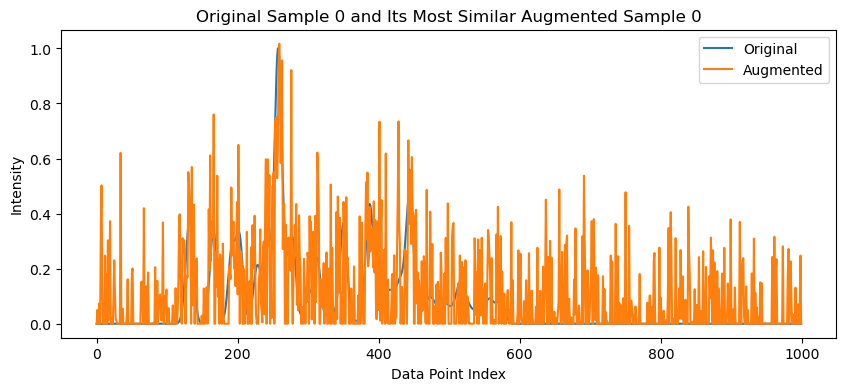

Most similar augmented data point for original sample 1 is augmented sample 1


Most similar augmented data point for original sample 2 is augmented sample 2


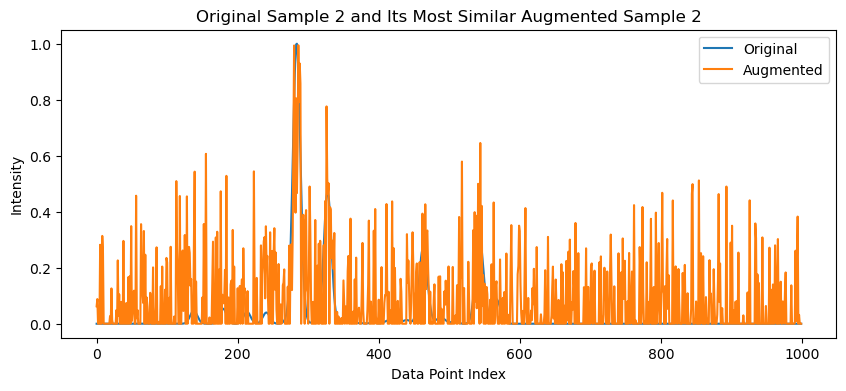

Most similar augmented data point for original sample 3 is augmented sample 3


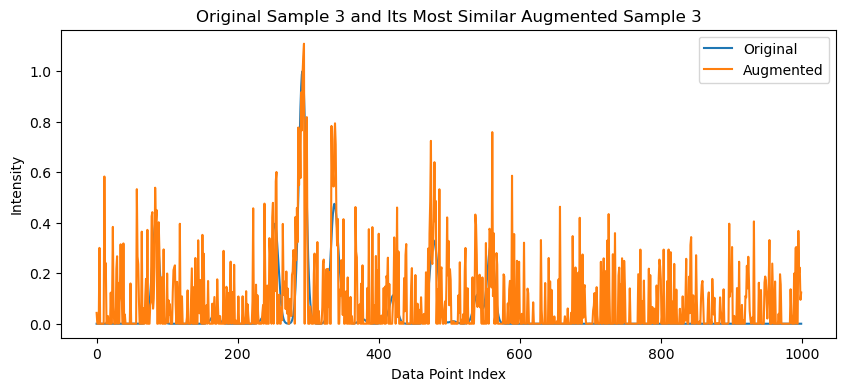

Most similar augmented data point for original sample 4 is augmented sample 4


Most similar augmented data point for original sample 5 is augmented sample 5


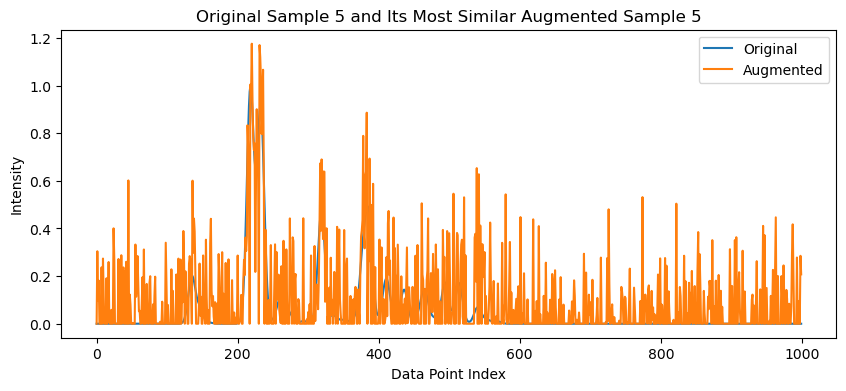

Most similar augmented data point for original sample 6 is augmented sample 6


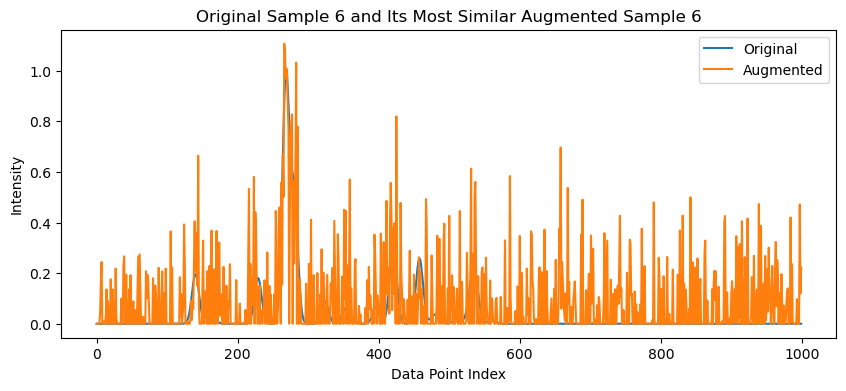

Most similar augmented data point for original sample 7 is augmented sample 7


Most similar augmented data point for original sample 8 is augmented sample 42


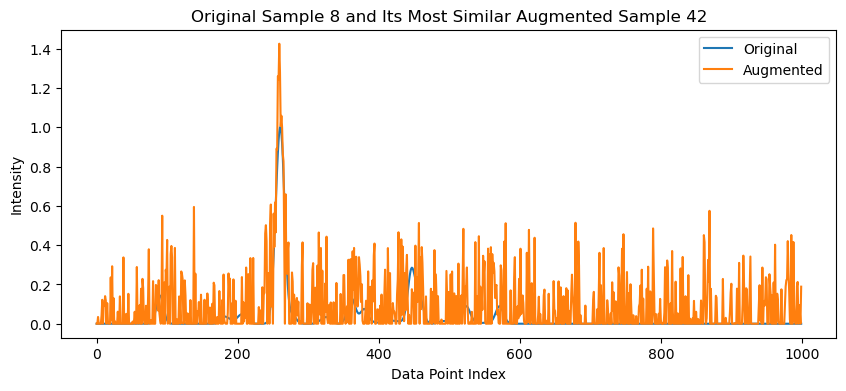

Most similar augmented data point for original sample 9 is augmented sample 59


Most similar augmented data point for original sample 10 is augmented sample 10


Most similar augmented data point for original sample 11 is augmented sample 11


Most similar augmented data point for original sample 12 is augmented sample 12


Most similar augmented data point for original sample 13 is augmented sample 13


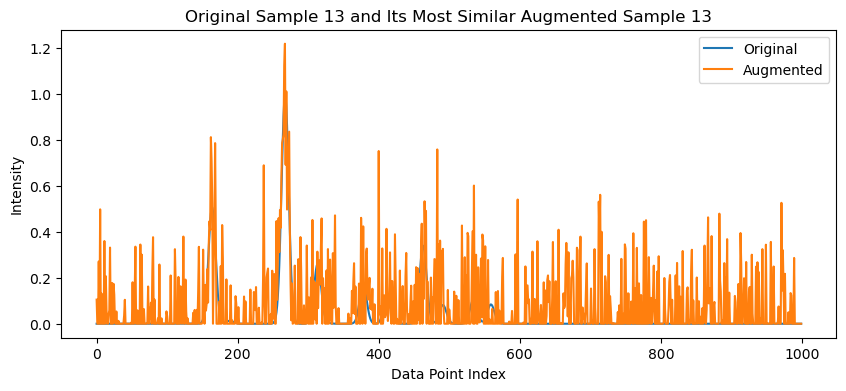

Most similar augmented data point for original sample 14 is augmented sample 14


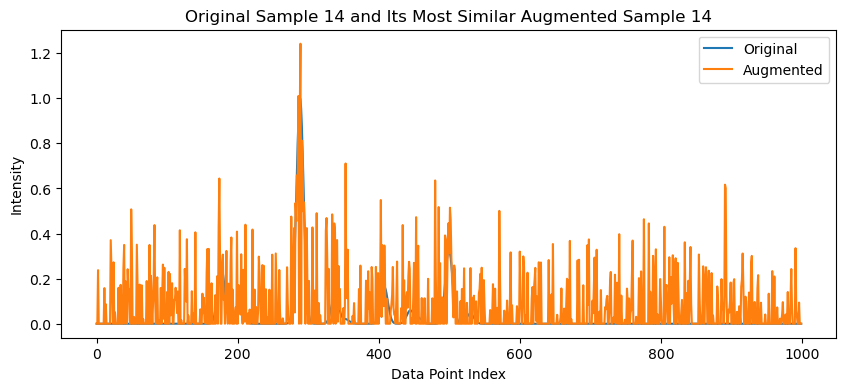

Most similar augmented data point for original sample 15 is augmented sample 15


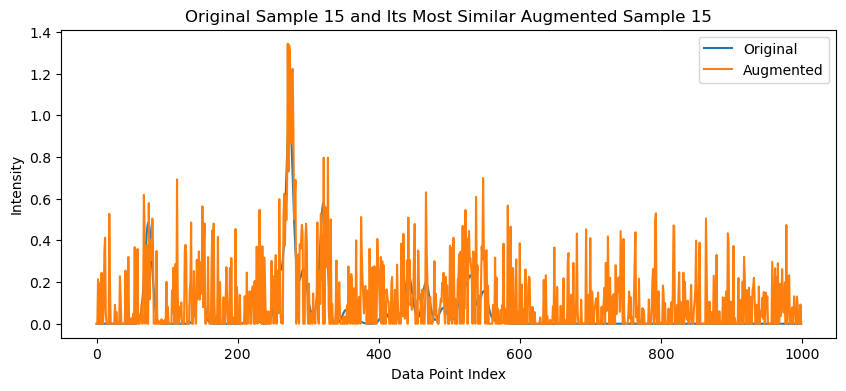

Most similar augmented data point for original sample 16 is augmented sample 16


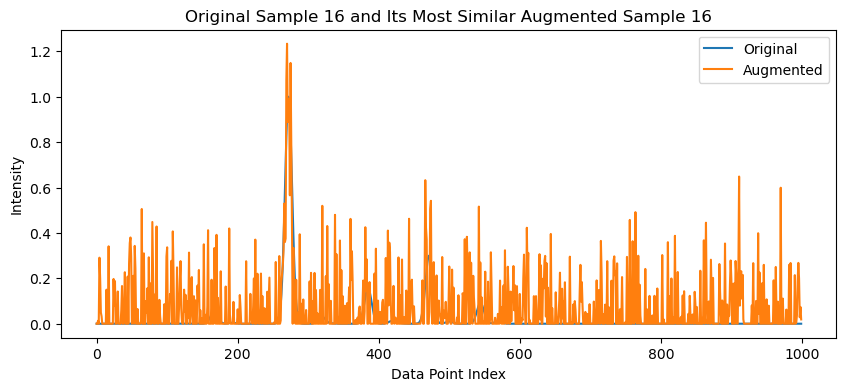

Most similar augmented data point for original sample 17 is augmented sample 17


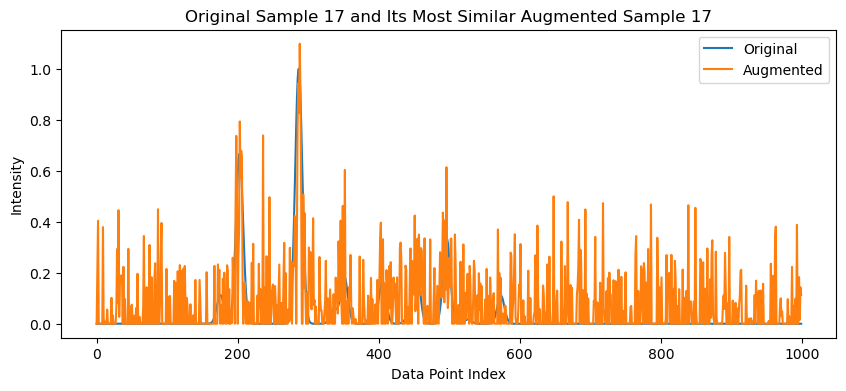

Most similar augmented data point for original sample 18 is augmented sample 18


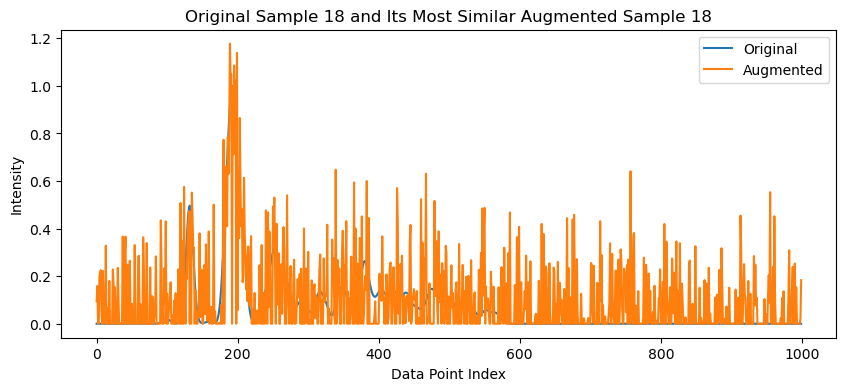

Most similar augmented data point for original sample 19 is augmented sample 19


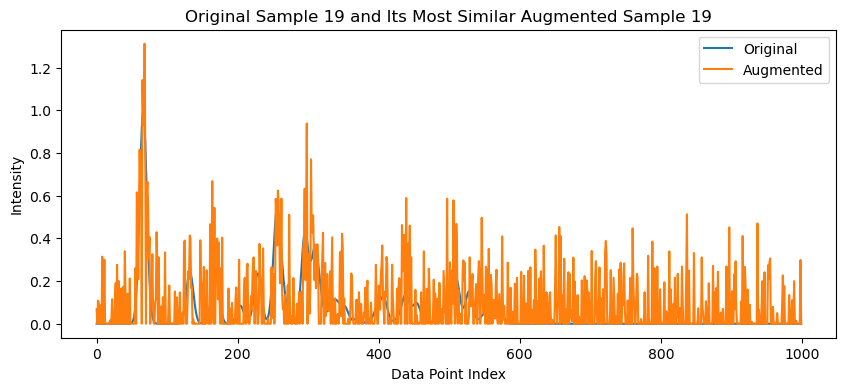

In [10]:
# Select an index to analyze
for idx in range(20):
    similar_idx = max_indices[idx]
    print(f"Most similar augmented data point for original sample {idx} is augmented sample {similar_idx}")

    # Plot the original and most similar augmented sample
    plt.figure(figsize=(10, 4))
    plt.plot(sample[idx].cpu().numpy(), label='Original')
    plt.plot(augmented_sample[similar_idx].cpu().numpy(), label='Augmented')
    plt.legend()
    plt.title(f'Original Sample {idx} and Its Most Similar Augmented Sample {similar_idx}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Intensity')
    plt.show()

In [14]:
# Imports (same as before)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import DeciferDataset
from pytorch_metric_learning.losses import SupConLoss
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from pymatgen.symmetry.groups import SpaceGroup  # Ensure pymatgen is installed

# Updated augmentation function (as provided)
def augmentation(xrd, intensity_scale_range=(0.9, 1.1), background_scale=0.05, mask_prob=0.1):
    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask

    # Clipping
    xrd_augmented = torch.clamp(xrd_augmented, min=0.0)

    return xrd_augmented

# Model definitions (same as before)
class CLEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CLEncoder, self).__init__()
        # Encoder head
        self.enc = nn.Linear(input_dim, 128)
        
        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, data, train=True):
        if train:
            # Get two augmentations of the same batch
            augm1 = augmentation(data)
            augm2 = augmentation(data)
        
            # Extract encoder embeddings
            h_1 = self.enc(augm1)
            h_2 = self.enc(augm2)

            # Extract low dim embeddings
            h_1_latent = self.proj(h_1)
            h_2_latent = self.proj(h_2)
            return h_1, h_2, h_1_latent, h_2_latent
        else:
            # Extract encoder embeddings
            h = self.enc(data)
            return h

# Initialize models (same as before)
xrd_input_dim = 1000  # Adjust according to your data
embedding_dim = 12

xrd_encoder = CLEncoder(xrd_input_dim, embedding_dim)

# Optimizer and device (same as before)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Dataset and DataLoader with "spacegroup" and "species"
dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq", "spacegroup", "species"])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Precompute the mapping from spacegroup symbols to numbers
spacegroup_symbols = set()
for item in tqdm(dataset):
    spacegroup_symbols.add(item[1])

# Use pymatgen to map symbols to numbers once
spacegroup_symbol_to_number = {}
for symbol in tqdm(spacegroup_symbols):
    try:
        sg_number = SpaceGroup(symbol).int_number
    except ValueError:
        # Handle invalid spacegroup symbols if necessary
        sg_number = -1  # Assign a default or error code
    spacegroup_symbol_to_number[symbol] = sg_number

# Map spacegroup numbers to indices for labels (consecutive integers)
unique_spacegroup_numbers = sorted(set(spacegroup_symbol_to_number.values()))
if -1 in unique_spacegroup_numbers:
    unique_spacegroup_numbers.remove(-1)  # Remove the error code if present
spacegroup_number_to_idx = {sg_num: idx for idx, sg_num in enumerate(unique_spacegroup_numbers)}

# Use Supervised Contrastive Loss
loss_function = SupConLoss(temperature=0.07)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        xrd = batch[0].to(device)
        sg_labels = batch[1]  # spacegroup symbols

        # Convert symbols to numbers using the precomputed mapping
        sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

        # Handle any invalid spacegroup numbers
        valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
        if not valid_indices:
            continue  # Skip batch if all spacegroups are invalid

        xrd = xrd[valid_indices]
        sg_numbers = [sg_numbers[i] for i in valid_indices]

        # Map spacegroup numbers to indices
        sg_indices = torch.tensor([spacegroup_number_to_idx[num] for num in sg_numbers], device=device)

        optimizer.zero_grad()

        # Forward pass
        h_1, h_2, h_1_latent, h_2_latent = xrd_encoder(xrd)
        
        # Prepare embeddings and labels
        embeddings = torch.cat((h_1_latent, h_2_latent), dim=0)
        labels = torch.cat((sg_indices, sg_indices), dim=0)
        
        # Compute loss
        loss = loss_function(embeddings, labels)
        loss.backward()
        optimizer.step()

        batch_size = xrd.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualization with "spacegroup" numbers
# Get a sample batch
sample_batch = next(iter(dataloader))
sample = sample_batch[0].to(device)
sg_labels = sample_batch[1]  # spacegroup symbols

# Convert symbols to numbers using the precomputed mapping
sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

# Handle any invalid spacegroup numbers
valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
if not valid_indices:
    raise ValueError("No valid spacegroup numbers in sample batch for visualization.")

sample = sample[valid_indices]
sg_numbers = [sg_numbers[i] for i in valid_indices]

# Get representations
with torch.no_grad():
    h_original = xrd_encoder(sample, train=False).cpu()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_original.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': h_embedded[:, 0],
    'y': h_embedded[:, 1],
    'spacegroup_number': sg_numbers
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='spacegroup_number', data=df, palette='tab20', legend='full')
plt.title('t-SNE Embedding Colored by Spacegroup Number')
plt.legend(title='Spacegroup Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Visualization and Similarity Analysis

# Get a sample batch
sample_batch = next(iter(dataloader))
sample = sample_batch[0].to(device)
sg_labels = sample_batch[1]  # spacegroup symbols

# Convert symbols to numbers using the precomputed mapping
sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

# Handle any invalid spacegroup numbers
valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
if not valid_indices:
    raise ValueError("No valid spacegroup numbers in sample batch for visualization.")

sample = sample[valid_indices]
sg_numbers = [sg_numbers[i] for i in valid_indices]
sg_labels = [sg_labels[i] for i in valid_indices]  # Update sg_labels

# Generate augmented samples
augmented_sample = augmentation(sample)

# Get representations
with torch.no_grad():
    h_original = xrd_encoder(sample, train=False).cpu()
    h_augmented = xrd_encoder(augmented_sample, train=False).cpu()

# Combine representations
h_combined = torch.cat([h_original, h_augmented], dim=0)

# Create labels for visualization
labels = np.array(['Original']*h_original.size(0) + ['Augmented']*h_augmented.size(0))
spacegroup_numbers_combined = sg_numbers + sg_numbers  # Duplicate for augmented samples

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_combined.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': h_embedded[:, 0],
    'y': h_embedded[:, 1],
    'Data Type': labels,
    'Spacegroup Number': spacegroup_numbers_combined
})

# Plot t-SNE embeddings colored by Data Type
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Data Type', style='Data Type', data=df, palette='Set1')
plt.title('t-SNE Embedding of Original and Augmented Data')
plt.legend(title='Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot t-SNE embeddings colored by Spacegroup Number
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Spacegroup Number', data=df, palette='tab20', legend='full')
plt.title('t-SNE Embedding Colored by Spacegroup Number')
plt.legend(title='Spacegroup Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Similarity analysis
def sim_matrix(a, b, eps=1e-8):
    """
    Compute cosine similarity between two sets of embeddings
    """
    a_n = a.norm(dim=1)[:, None]
    b_n = b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

# Compute similarity between original and augmented embeddings
similarity = sim_matrix(h_original, h_augmented)

# For each original sample, find the index of the most similar augmented sample
max_indices = similarity.argmax(dim=1)
max_vals = similarity.max(dim=1).values

# Analyze individual samples
for idx in range(len(sample)):
    similar_idx = max_indices[idx]
    print(f"Most similar augmented data point for original sample {idx} is augmented sample {similar_idx}")
    print(f"Cosine similarity: {max_vals[idx]:.4f}")
    # Plot the original and most similar augmented sample
    plt.figure(figsize=(10, 4))
    plt.plot(sample[idx].cpu().numpy(), label='Original')
    plt.plot(augmented_sample[similar_idx].cpu().numpy(), label='Augmented')
    plt.legend()
    plt.title(f'Original Sample {idx} and Its Most Similar Augmented Sample {similar_idx}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Intensity')
    plt.show()

  0%|          | 0/228338 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Using spacegroups as labels

  0%|          | 0/228338 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [1/2], Loss: 2.6135


Epoch 2/2:   0%|          | 0/7136 [00:00<?, ?it/s]

Epoch [2/2], Loss: 2.4798


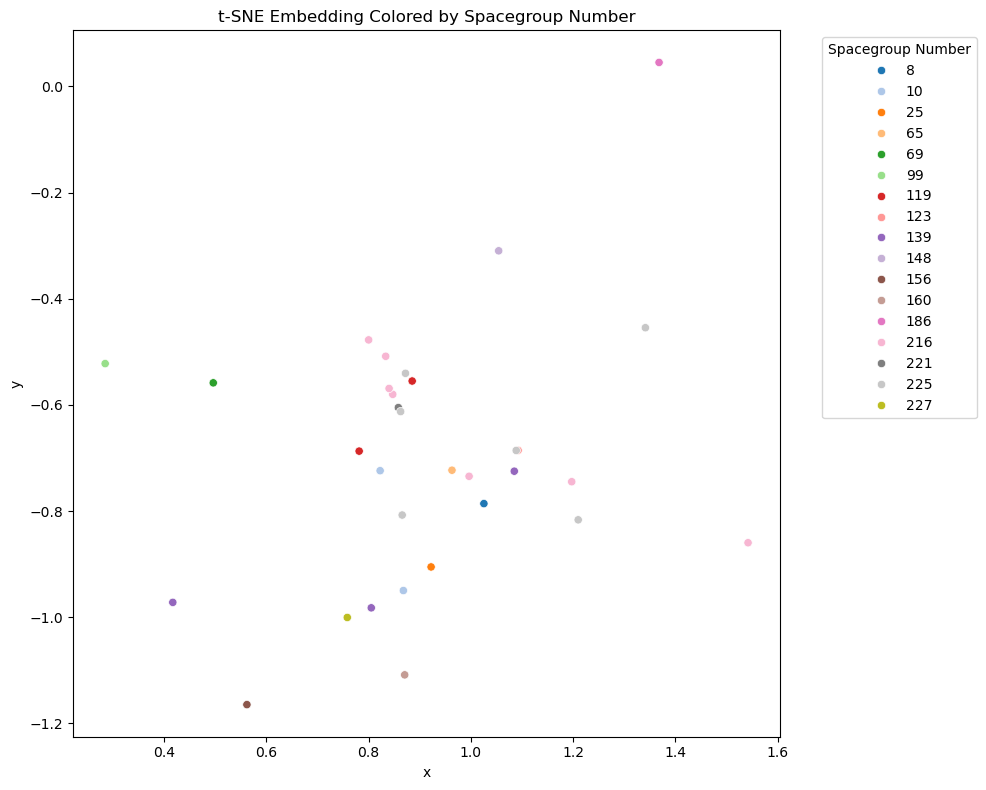

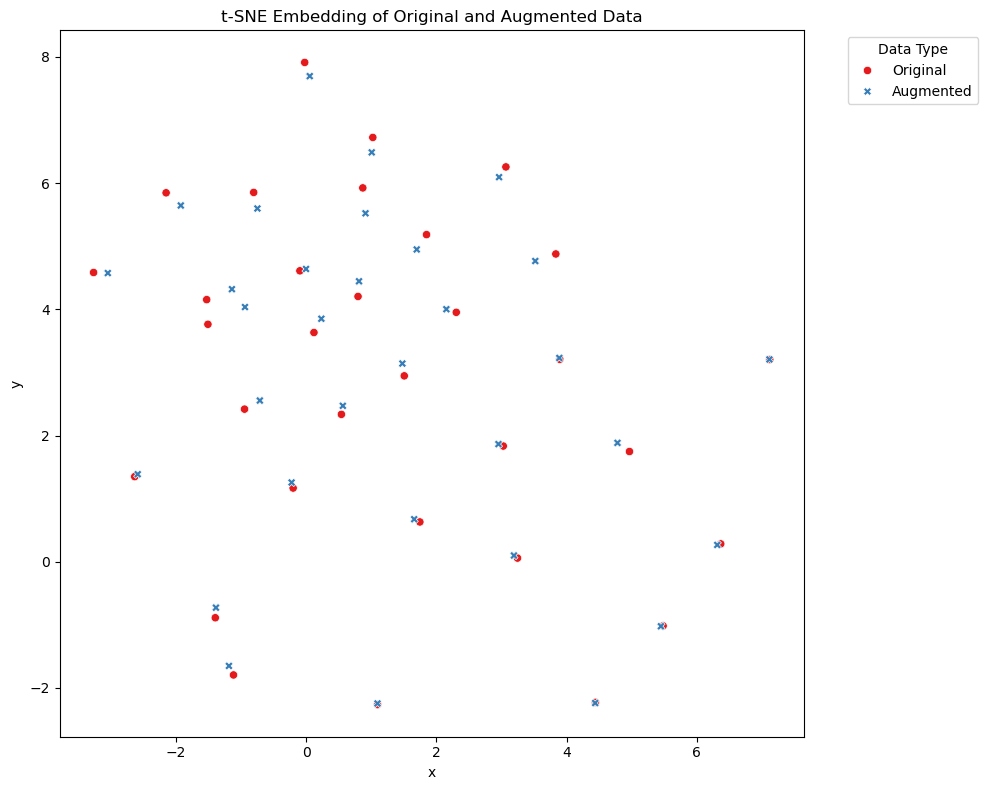

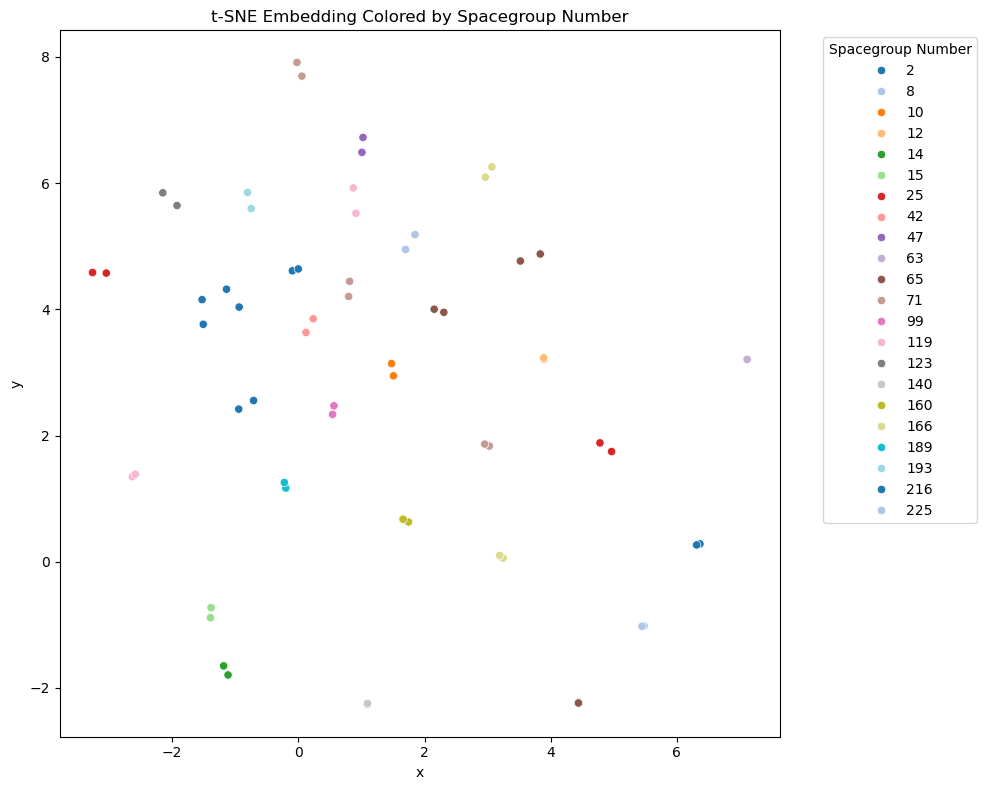

Most similar augmented data point for original sample 0 is augmented sample 0
Cosine similarity: 0.9789


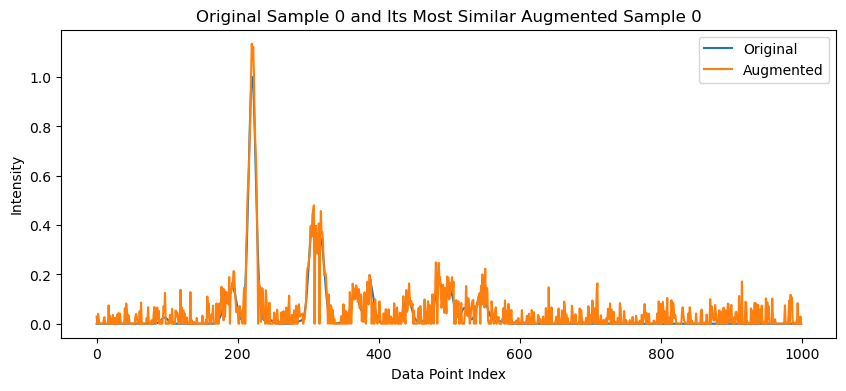

Most similar augmented data point for original sample 1 is augmented sample 1
Cosine similarity: 0.9650


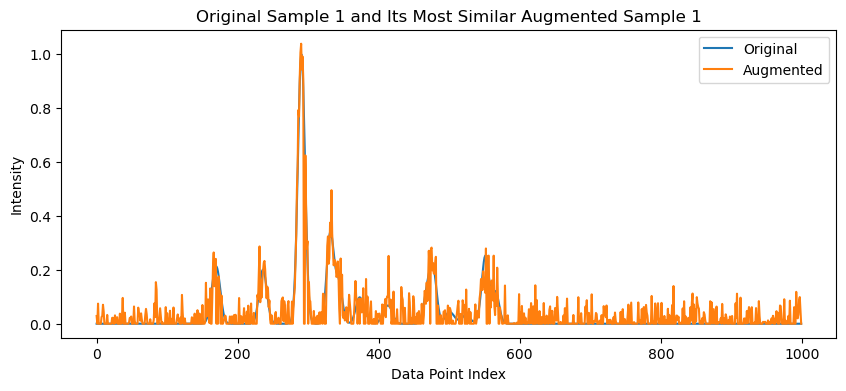

Most similar augmented data point for original sample 2 is augmented sample 2
Cosine similarity: 0.9937


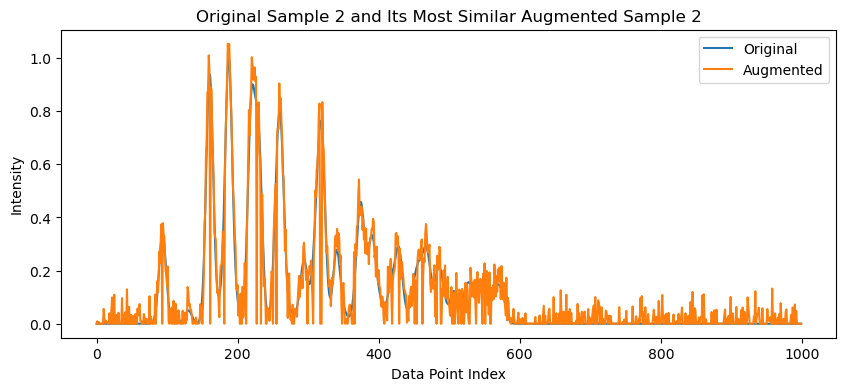

Most similar augmented data point for original sample 3 is augmented sample 3
Cosine similarity: 0.9561


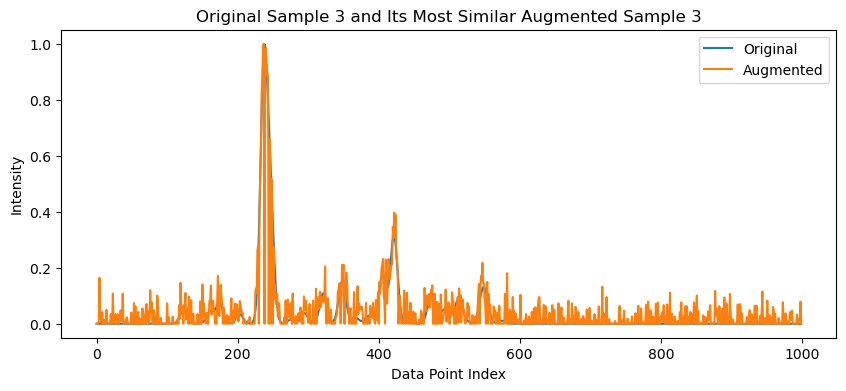

Most similar augmented data point for original sample 4 is augmented sample 4
Cosine similarity: 0.9780


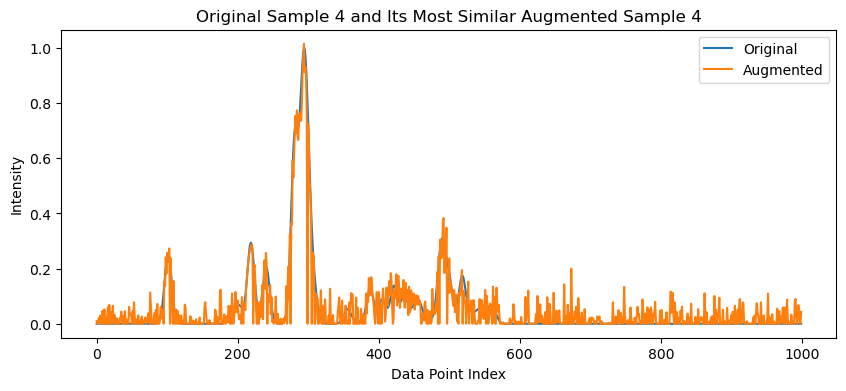

Most similar augmented data point for original sample 5 is augmented sample 5
Cosine similarity: 0.9534


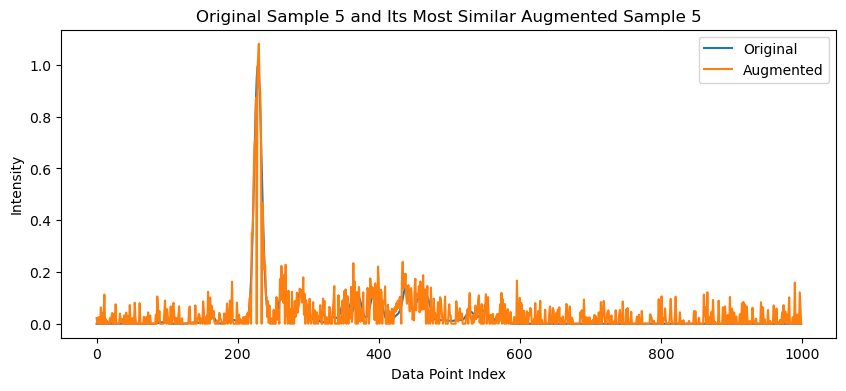

Most similar augmented data point for original sample 6 is augmented sample 6
Cosine similarity: 0.9775


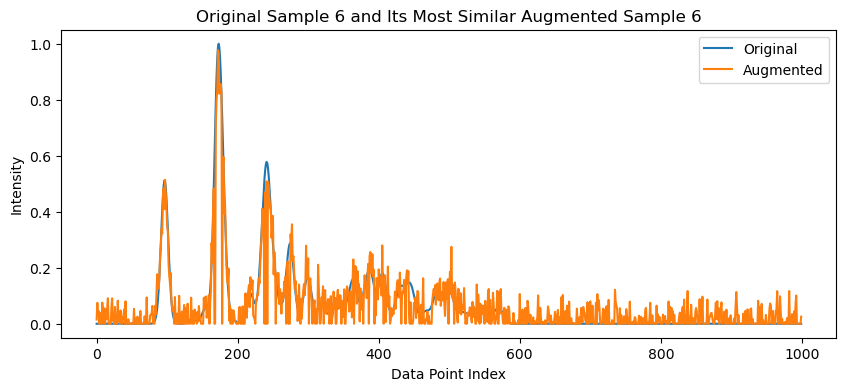

Most similar augmented data point for original sample 7 is augmented sample 7
Cosine similarity: 0.9864


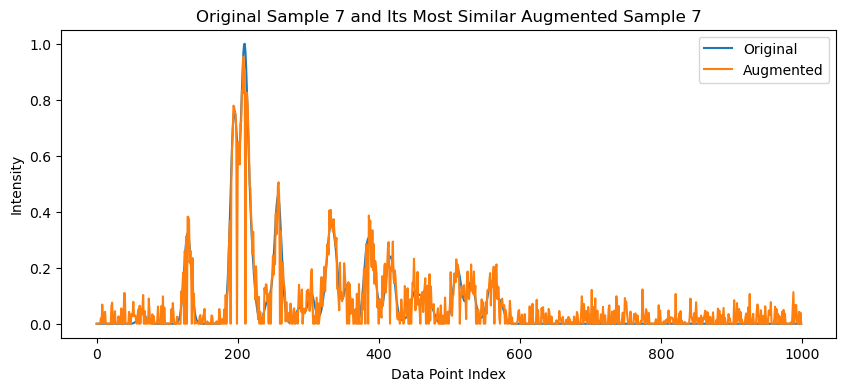

Most similar augmented data point for original sample 8 is augmented sample 8
Cosine similarity: 0.9460


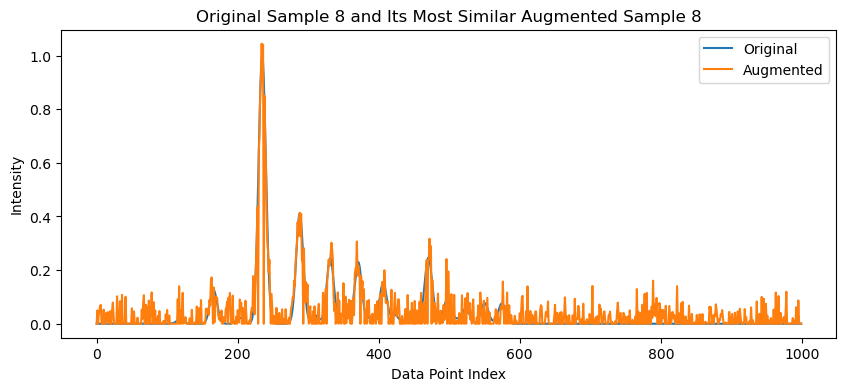

Most similar augmented data point for original sample 9 is augmented sample 9
Cosine similarity: 0.9431


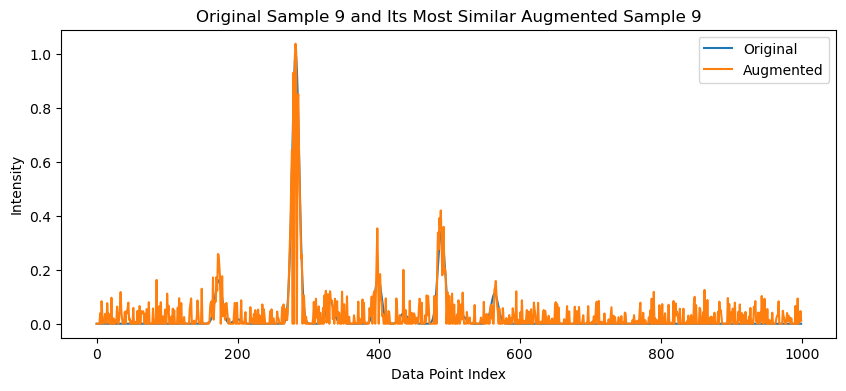

Most similar augmented data point for original sample 10 is augmented sample 10
Cosine similarity: 0.9873


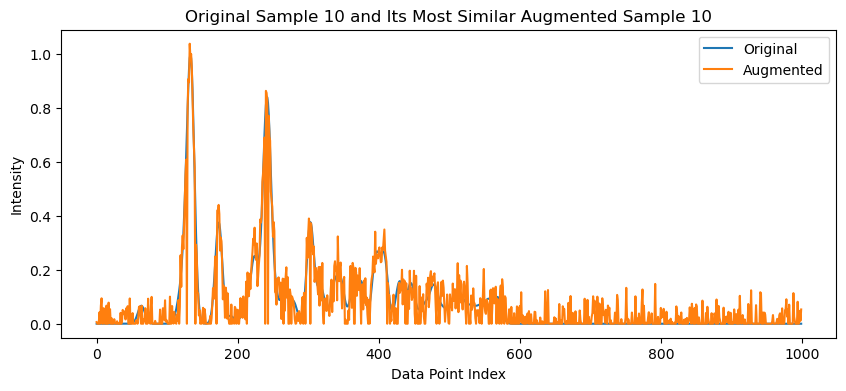

Most similar augmented data point for original sample 11 is augmented sample 11
Cosine similarity: 0.9672


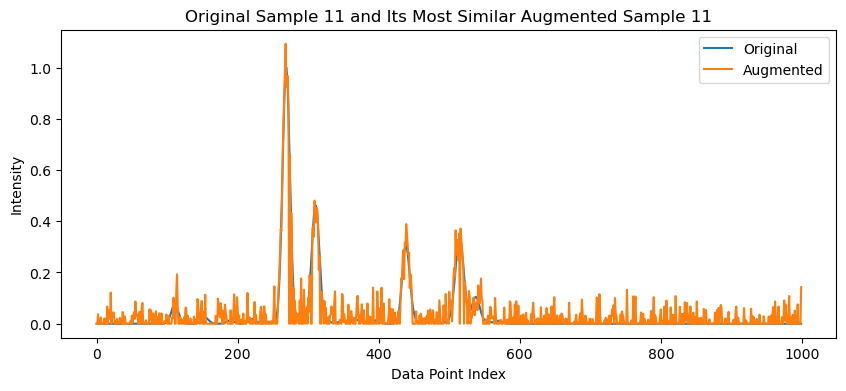

Most similar augmented data point for original sample 12 is augmented sample 12
Cosine similarity: 0.9383


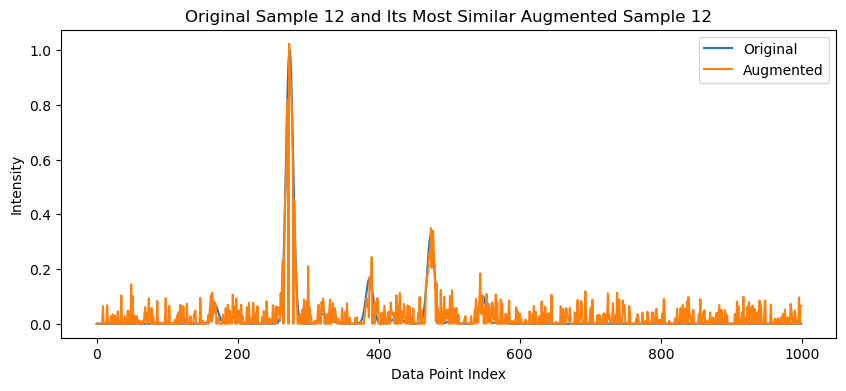

Most similar augmented data point for original sample 13 is augmented sample 13
Cosine similarity: 0.9353


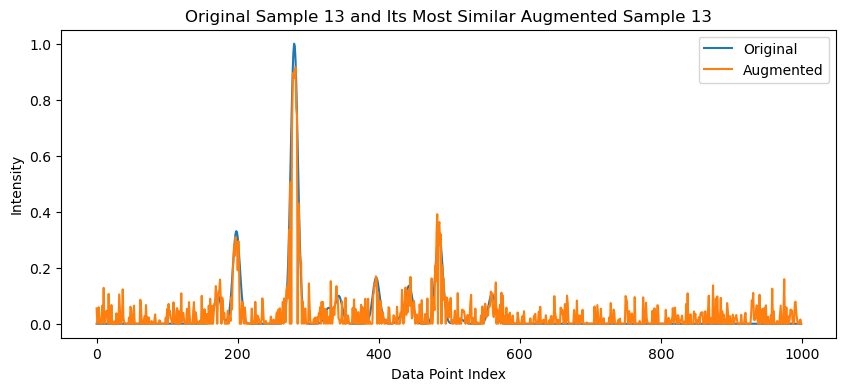

Most similar augmented data point for original sample 14 is augmented sample 14
Cosine similarity: 0.9812


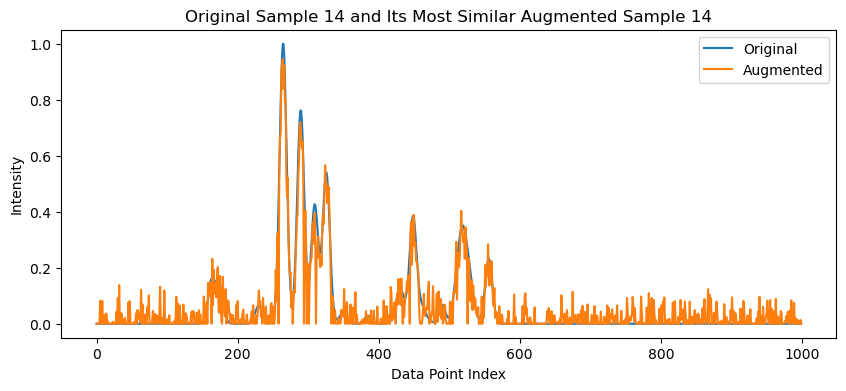

Most similar augmented data point for original sample 15 is augmented sample 15
Cosine similarity: 0.9695


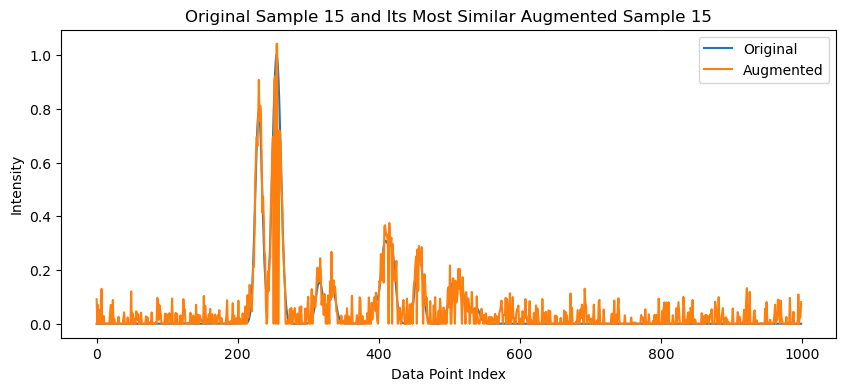

Most similar augmented data point for original sample 16 is augmented sample 16
Cosine similarity: 0.9785


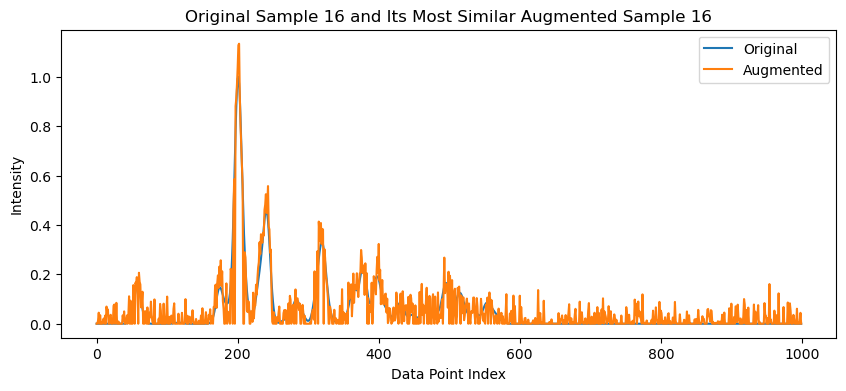

Most similar augmented data point for original sample 17 is augmented sample 17
Cosine similarity: 0.9794


Most similar augmented data point for original sample 18 is augmented sample 18
Cosine similarity: 0.9904


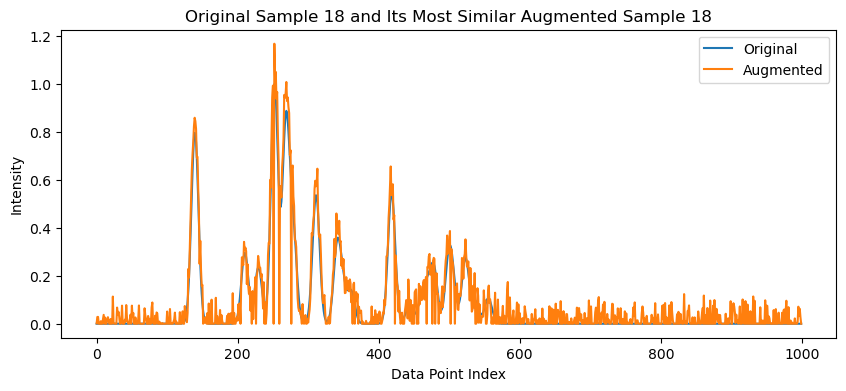

Most similar augmented data point for original sample 19 is augmented sample 19
Cosine similarity: 0.9102


Most similar augmented data point for original sample 20 is augmented sample 20
Cosine similarity: 0.9533


Most similar augmented data point for original sample 21 is augmented sample 21
Cosine similarity: 0.9564


Most similar augmented data point for original sample 22 is augmented sample 22
Cosine similarity: 0.9723


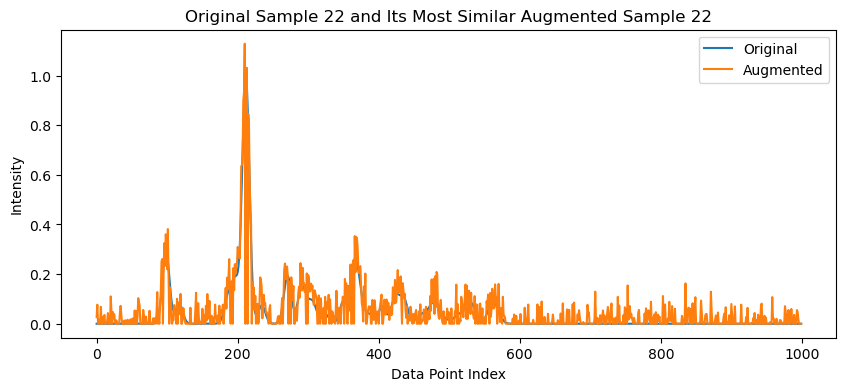

Most similar augmented data point for original sample 23 is augmented sample 23
Cosine similarity: 0.9613


Most similar augmented data point for original sample 24 is augmented sample 24
Cosine similarity: 0.9558


Most similar augmented data point for original sample 25 is augmented sample 25
Cosine similarity: 0.9876


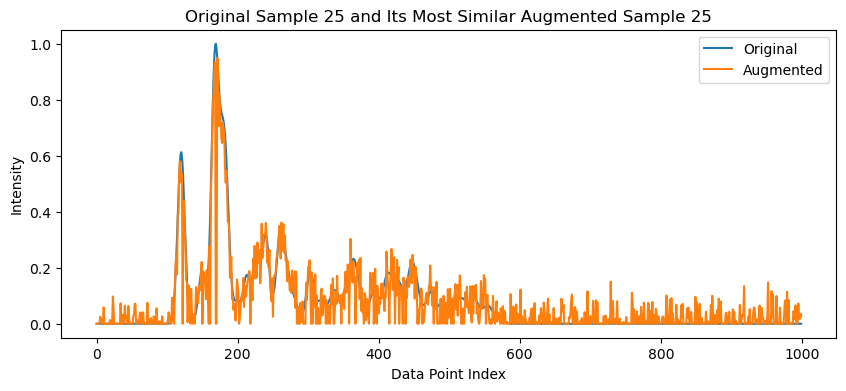

Most similar augmented data point for original sample 26 is augmented sample 26
Cosine similarity: 0.9642


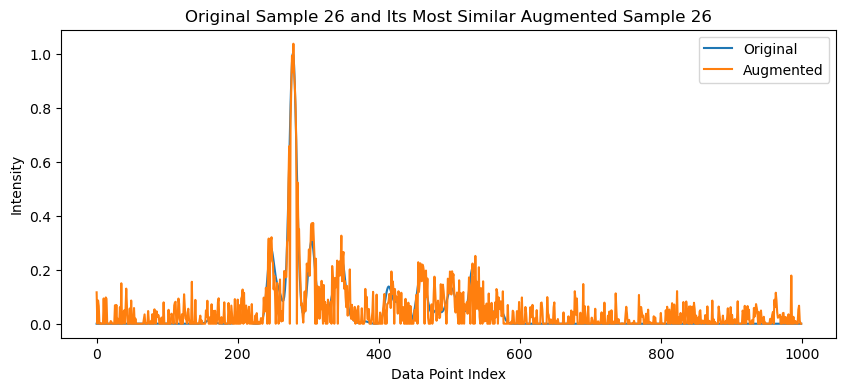

Most similar augmented data point for original sample 27 is augmented sample 27
Cosine similarity: 0.9781


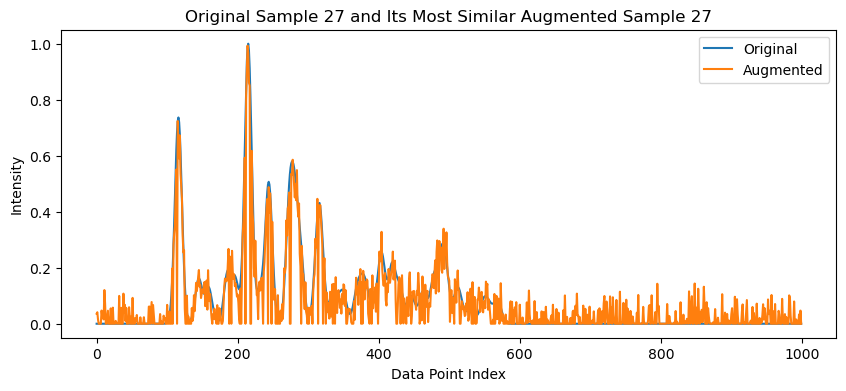

Most similar augmented data point for original sample 28 is augmented sample 28
Cosine similarity: 0.9907


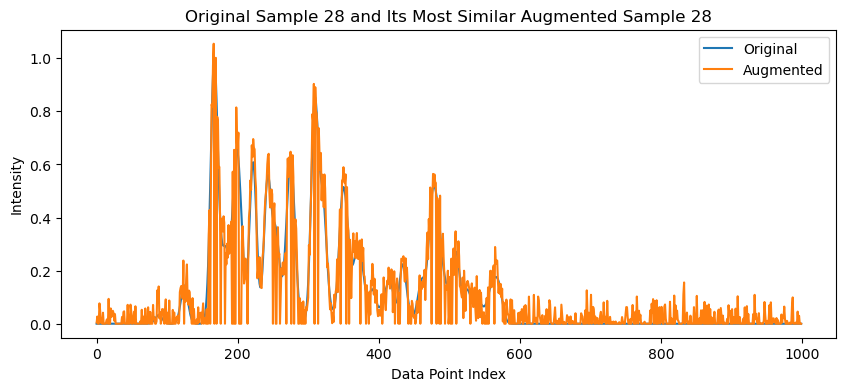

Most similar augmented data point for original sample 29 is augmented sample 29
Cosine similarity: 0.9760


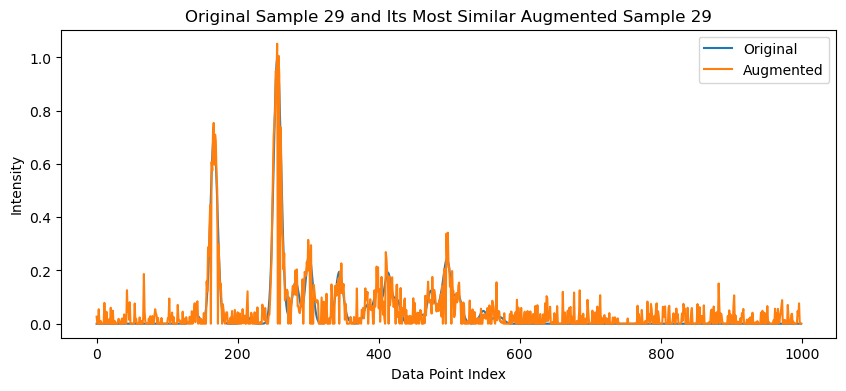

Most similar augmented data point for original sample 30 is augmented sample 30
Cosine similarity: 0.9354


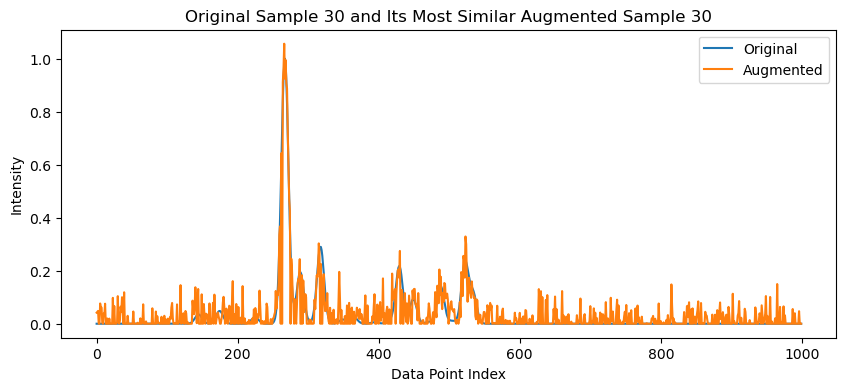

Most similar augmented data point for original sample 31 is augmented sample 31
Cosine similarity: 0.9902


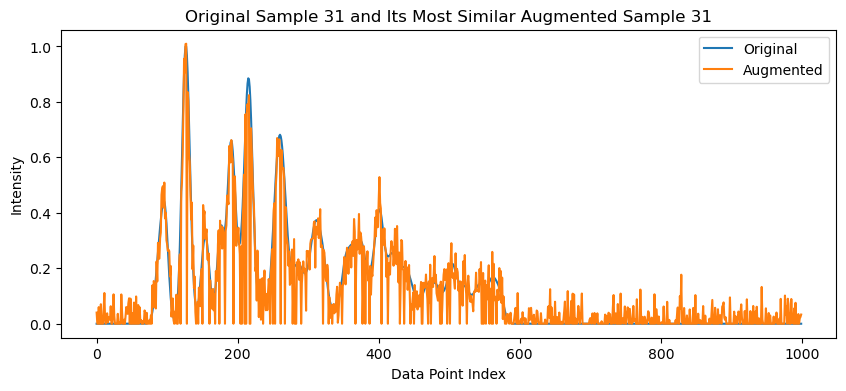

In [2]:
# Imports (same as before)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import DeciferDataset
from pytorch_metric_learning.losses import SupConLoss
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from pymatgen.symmetry.groups import SpaceGroup  # Ensure pymatgen is installed

# Updated augmentation function (as provided)
def augmentation(xrd, intensity_scale_range=(0.9, 1.1), background_scale=0.05, mask_prob=0.1):
    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask

    # Clipping
    xrd_augmented = torch.clamp(xrd_augmented, min=0.0)

    return xrd_augmented

# Model definitions (same as before)
class CLEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CLEncoder, self).__init__()
        # Encoder head
        self.enc = nn.Linear(input_dim, 128)
        
        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, data, train=True):
        if train:
            # Get two augmentations of the same batch
            augm1 = augmentation(data)
            augm2 = augmentation(data)
        
            # Extract encoder embeddings
            h_1 = self.enc(augm1)
            h_2 = self.enc(augm2)

            # Extract low dim embeddings
            h_1_latent = self.proj(h_1)
            h_2_latent = self.proj(h_2)
            return h_1, h_2, h_1_latent, h_2_latent
        else:
            # Extract encoder embeddings
            h = self.enc(data)
            return h

# Initialize models (same as before)
xrd_input_dim = 1000  # Adjust according to your data
embedding_dim = 32

xrd_encoder = CLEncoder(xrd_input_dim, embedding_dim)

# Optimizer and device (same as before)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Dataset and DataLoader with "spacegroup" and "species"
dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq", "spacegroup", "species"])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Precompute the mapping from spacegroup symbols to numbers
spacegroup_symbols = set()
for item in tqdm(dataset, desc="Extracting spacegroups"):
    spacegroup_symbols.add(item[1])

# Use pymatgen to map symbols to numbers once
spacegroup_symbol_to_number = {}
for symbol in tqdm(spacegroup_symbols):
    try:
        sg_number = SpaceGroup(symbol).int_number
    except ValueError:
        # Handle invalid spacegroup symbols if necessary
        sg_number = -1  # Assign a default or error code
        print(symbol)
    spacegroup_symbol_to_number[symbol] = sg_number

# Map spacegroup numbers to indices for labels (consecutive integers)
unique_spacegroup_numbers = sorted(set(spacegroup_symbol_to_number.values()))
if -1 in unique_spacegroup_numbers:
    unique_spacegroup_numbers.remove(-1)  # Remove the error code if present
spacegroup_number_to_idx = {sg_num: idx for idx, sg_num in enumerate(unique_spacegroup_numbers)}

# Use Supervised Contrastive Loss
loss_function = SupConLoss(temperature=0.07)

# Training loop
num_epochs = 2

for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        xrd = batch[0].to(device)
        sg_labels = batch[1]  # spacegroup symbols

        # Convert symbols to numbers using the precomputed mapping
        sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

        # Handle any invalid spacegroup numbers
        valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
        if not valid_indices:
            continue  # Skip batch if all spacegroups are invalid

        xrd = xrd[valid_indices]
        sg_numbers = [sg_numbers[i] for i in valid_indices]

        # Map spacegroup numbers to indices
        sg_indices = torch.tensor([spacegroup_number_to_idx[num] for num in sg_numbers], device=device)

        optimizer.zero_grad()

        # Forward pass
        h_1, h_2, h_1_latent, h_2_latent = xrd_encoder(xrd)
        
        # Prepare embeddings and labels
        embeddings = torch.cat((h_1_latent, h_2_latent), dim=0)
        labels = torch.cat((sg_indices, sg_indices), dim=0)
        
        # Compute loss
        loss = loss_function(embeddings, labels)
        loss.backward()
        optimizer.step()

        batch_size = xrd.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualization with "spacegroup" numbers
# Get a sample batch
sample_batch = next(iter(dataloader))
sample = sample_batch[0].to(device)
sg_labels = sample_batch[1]  # spacegroup symbols

# Convert symbols to numbers using the precomputed mapping
sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

# Handle any invalid spacegroup numbers
valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
if not valid_indices:
    raise ValueError("No valid spacegroup numbers in sample batch for visualization.")

sample = sample[valid_indices]
sg_numbers = [sg_numbers[i] for i in valid_indices]

# Get representations
with torch.no_grad():
    h_original = xrd_encoder(sample, train=False).cpu()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_original.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': h_embedded[:, 0],
    'y': h_embedded[:, 1],
    'spacegroup_number': sg_numbers
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='spacegroup_number', data=df, palette='tab20', legend='full')
plt.title('t-SNE Embedding Colored by Spacegroup Number')
plt.legend(title='Spacegroup Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Visualization and Similarity Analysis

# Get a sample batch
sample_batch = next(iter(dataloader))
sample = sample_batch[0].to(device)
sg_labels = sample_batch[1]  # spacegroup symbols

# Convert symbols to numbers using the precomputed mapping
sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

# Handle any invalid spacegroup numbers
valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
if not valid_indices:
    raise ValueError("No valid spacegroup numbers in sample batch for visualization.")

sample = sample[valid_indices]
sg_numbers = [sg_numbers[i] for i in valid_indices]
sg_labels = [sg_labels[i] for i in valid_indices]  # Update sg_labels

# Generate augmented samples
augmented_sample = augmentation(sample)

# Get representations
with torch.no_grad():
    h_original = xrd_encoder(sample, train=False).cpu()
    h_augmented = xrd_encoder(augmented_sample, train=False).cpu()

# Combine representations
h_combined = torch.cat([h_original, h_augmented], dim=0)

# Create labels for visualization
labels = np.array(['Original']*h_original.size(0) + ['Augmented']*h_augmented.size(0))
spacegroup_numbers_combined = sg_numbers + sg_numbers  # Duplicate for augmented samples

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_combined.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': h_embedded[:, 0],
    'y': h_embedded[:, 1],
    'Data Type': labels,
    'Spacegroup Number': spacegroup_numbers_combined
})

# Plot t-SNE embeddings colored by Data Type
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Data Type', style='Data Type', data=df, palette='Set1')
plt.title('t-SNE Embedding of Original and Augmented Data')
plt.legend(title='Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot t-SNE embeddings colored by Spacegroup Number
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Spacegroup Number', data=df, palette='tab20', legend='full')
plt.title('t-SNE Embedding Colored by Spacegroup Number')
plt.legend(title='Spacegroup Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Similarity analysis
def sim_matrix(a, b, eps=1e-8):
    """
    Compute cosine similarity between two sets of embeddings
    """
    a_n = a.norm(dim=1)[:, None]
    b_n = b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

# Compute similarity between original and augmented embeddings
similarity = sim_matrix(h_original, h_augmented)

# For each original sample, find the index of the most similar augmented sample
max_indices = similarity.argmax(dim=1)
max_vals = similarity.max(dim=1).values

# Analyze individual samples
for idx in range(len(sample)):
    similar_idx = max_indices[idx]
    print(f"Most similar augmented data point for original sample {idx} is augmented sample {similar_idx}")
    print(f"Cosine similarity: {max_vals[idx]:.4f}")
    # Plot the original and most similar augmented sample
    plt.figure(figsize=(10, 4))
    plt.plot(sample[idx].cpu().numpy(), label='Original')
    plt.plot(augmented_sample[similar_idx].cpu().numpy(), label='Augmented')
    plt.legend()
    plt.title(f'Original Sample {idx} and Its Most Similar Augmented Sample {similar_idx}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Intensity')
    plt.show()

# (Subset) Use spacegroups as labels

Epoch 1/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/500], Loss: 4.6689


Epoch 11/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/500], Loss: 4.3315


Epoch 21/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/500], Loss: 4.0153


Epoch 31/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/500], Loss: 3.7452


Epoch 41/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/500], Loss: 3.4964


Epoch 51/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 56/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/500], Loss: 3.2764


Epoch 61/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 66/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 70/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/500], Loss: 3.1307


Epoch 71/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 72/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 73/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 74/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 75/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 76/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 77/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 78/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 79/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 80/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/500], Loss: 3.0323


Epoch 81/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 82/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 83/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 84/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 85/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 86/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 87/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 88/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 89/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 90/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/500], Loss: 2.9246


Epoch 91/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 92/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 93/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 94/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 95/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 96/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 97/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 98/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 99/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 100/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/500], Loss: 2.8822


Epoch 101/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 102/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 103/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 104/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 105/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 106/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 107/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 108/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 109/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 110/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110/500], Loss: 2.8091


Epoch 111/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 112/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 113/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 114/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 115/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 116/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 117/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 118/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 119/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 120/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120/500], Loss: 2.7945


Epoch 121/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 122/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 123/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 124/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 125/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 126/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 127/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 128/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 129/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 130/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130/500], Loss: 2.7096


Epoch 131/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 132/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 133/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 134/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 135/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 136/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 137/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 138/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 139/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 140/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140/500], Loss: 2.6818


Epoch 141/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 142/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 143/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 144/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 145/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 146/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 147/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 148/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 149/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 150/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150/500], Loss: 2.6775


Epoch 151/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 152/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 153/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 154/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 155/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 156/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 157/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 158/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 159/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 160/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [160/500], Loss: 2.6698


Epoch 161/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 162/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 163/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 164/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 165/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 166/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 167/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 168/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 169/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 170/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [170/500], Loss: 2.6436


Epoch 171/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 172/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 173/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 174/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 175/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 176/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 177/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 178/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 179/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 180/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [180/500], Loss: 2.5901


Epoch 181/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 182/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 183/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 184/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 185/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 186/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 187/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 188/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 189/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 190/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [190/500], Loss: 2.6313


Epoch 191/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 192/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 193/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 194/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 195/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 196/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 197/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 198/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 199/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 200/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [200/500], Loss: 2.5892


Epoch 201/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 202/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 203/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 204/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 205/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 206/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 207/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 208/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 209/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 210/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [210/500], Loss: 2.6134


Epoch 211/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 212/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 213/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 214/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 215/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 216/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 217/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 218/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 219/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 220/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [220/500], Loss: 2.5690


Epoch 221/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 222/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 223/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 224/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 225/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 226/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 227/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 228/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 229/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 230/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [230/500], Loss: 2.5862


Epoch 231/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 232/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 233/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 234/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 235/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 236/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 237/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 238/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 239/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 240/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [240/500], Loss: 2.5939


Epoch 241/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 242/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 243/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 244/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 245/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 246/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 247/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 248/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 249/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 250/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [250/500], Loss: 2.5371


Epoch 251/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 252/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 253/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 254/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 255/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 256/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 257/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 258/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 259/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 260/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [260/500], Loss: 2.5839


Epoch 261/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 262/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 263/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 264/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 265/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 266/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 267/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 268/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 269/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 270/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [270/500], Loss: 2.5494


Epoch 271/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 272/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 273/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 274/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 275/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 276/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 277/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 278/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 279/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 280/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [280/500], Loss: 2.5165


Epoch 281/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 282/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 283/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 284/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 285/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 286/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 287/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 288/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 289/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 290/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [290/500], Loss: 2.5564


Epoch 291/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 292/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 293/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 294/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 295/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 296/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 297/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 298/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 299/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 300/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [300/500], Loss: 2.5149


Epoch 301/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 302/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 303/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 304/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 305/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 306/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 307/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 308/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 309/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 310/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [310/500], Loss: 2.5025


Epoch 311/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 312/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 313/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 314/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 315/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 316/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 317/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 318/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 319/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 320/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [320/500], Loss: 2.5080


Epoch 321/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 322/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 323/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 324/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 325/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 326/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 327/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 328/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 329/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 330/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [330/500], Loss: 2.5337


Epoch 331/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 332/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 333/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 334/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 335/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 336/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 337/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 338/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 339/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 340/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [340/500], Loss: 2.5078


Epoch 341/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 342/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 343/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 344/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 345/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 346/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 347/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 348/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 349/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 350/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [350/500], Loss: 2.5098


Epoch 351/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 352/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 353/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 354/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 355/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 356/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 357/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 358/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 359/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 360/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [360/500], Loss: 2.5069


Epoch 361/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 362/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 363/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 364/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 365/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 366/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 367/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 368/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 369/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 370/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [370/500], Loss: 2.5070


Epoch 371/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 372/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 373/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 374/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 375/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 376/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 377/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 378/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 379/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 380/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [380/500], Loss: 2.5247


Epoch 381/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 382/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 383/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 384/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 385/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 386/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 387/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 388/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 389/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 390/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [390/500], Loss: 2.5117


Epoch 391/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 392/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 393/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 394/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 395/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 396/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 397/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 398/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 399/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 400/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [400/500], Loss: 2.5256


Epoch 401/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 402/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 403/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 404/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 405/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 406/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 407/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 408/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 409/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 410/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [410/500], Loss: 2.4866


Epoch 411/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 412/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 413/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 414/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 415/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 416/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 417/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 418/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 419/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 420/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [420/500], Loss: 2.4712


Epoch 421/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 422/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 423/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 424/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 425/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 426/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 427/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 428/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 429/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 430/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [430/500], Loss: 2.4761


Epoch 431/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 432/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 433/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 434/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 435/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 436/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 437/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 438/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 439/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 440/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [440/500], Loss: 2.5015


Epoch 441/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 442/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 443/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 444/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 445/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 446/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 447/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 448/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 449/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 450/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [450/500], Loss: 2.4957


Epoch 451/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 452/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 453/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 454/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 455/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 456/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 457/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 458/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 459/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 460/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [460/500], Loss: 2.4911


Epoch 461/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 462/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 463/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 464/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 465/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 466/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 467/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 468/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 469/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 470/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [470/500], Loss: 2.5071


Epoch 471/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 472/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 473/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 474/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 475/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 476/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 477/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 478/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 479/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 480/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [480/500], Loss: 2.4915


Epoch 481/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 482/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 483/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 484/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 485/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 486/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 487/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 488/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 489/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 490/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [490/500], Loss: 2.4753


Epoch 491/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 492/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 493/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 494/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 495/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 496/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 497/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 498/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 499/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 500/500:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [500/500], Loss: 2.4756


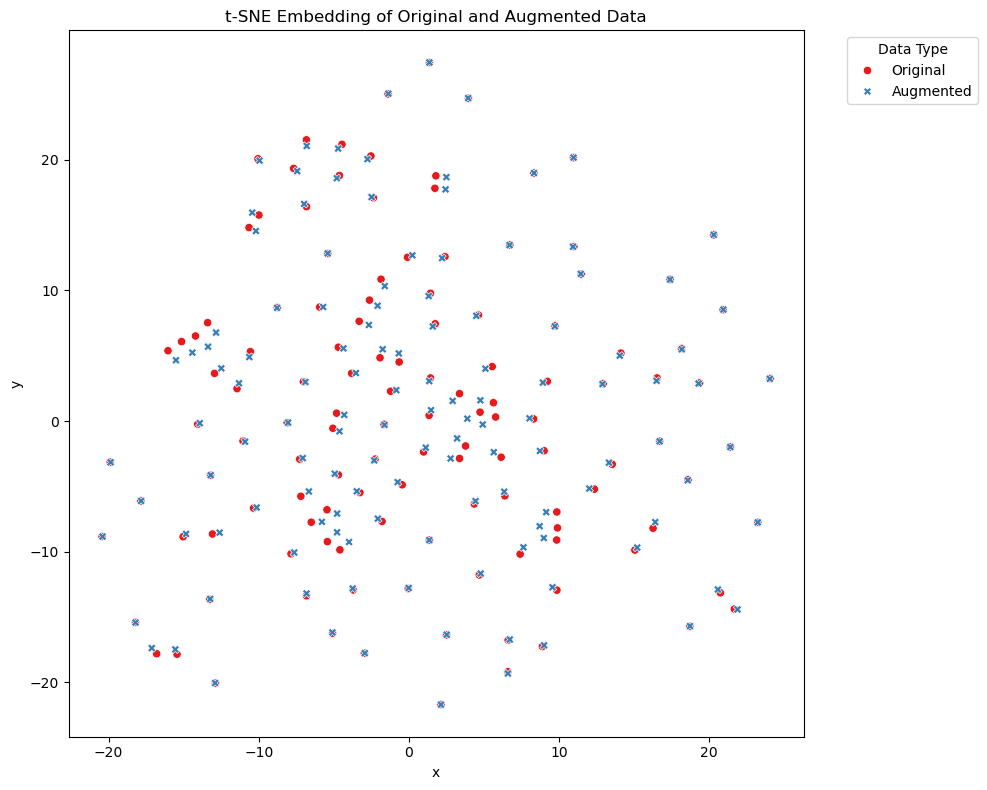

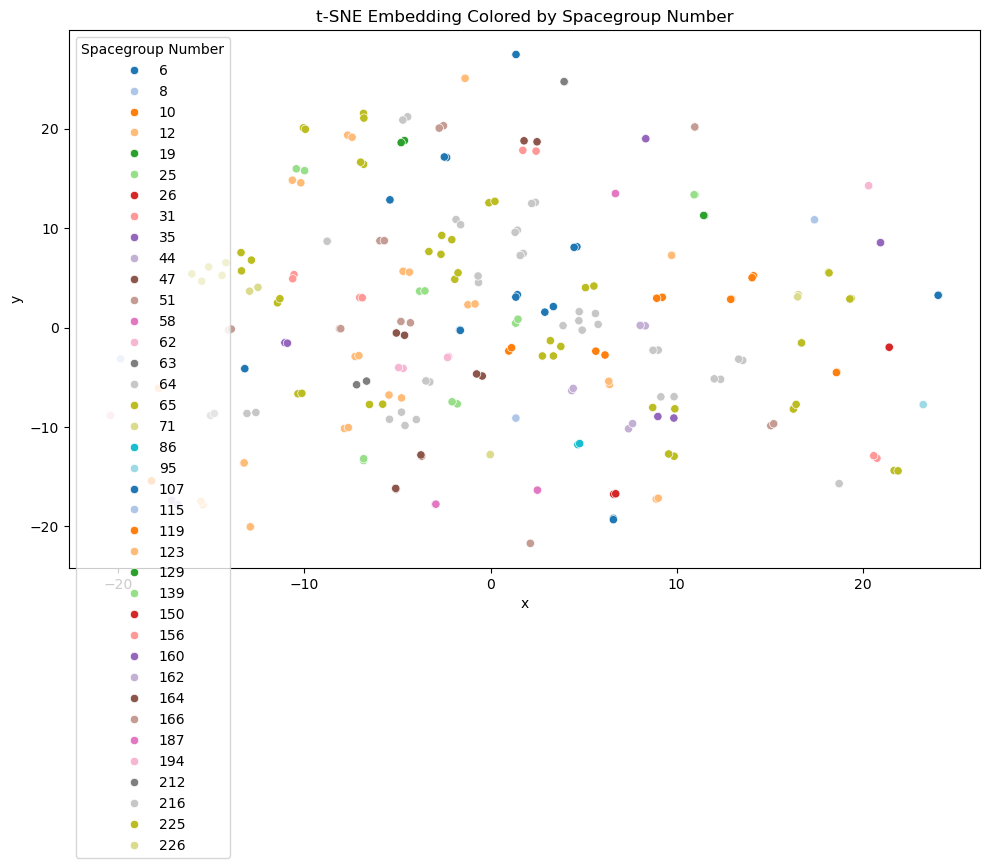

Most similar augmented data point for original sample 0 is augmented sample 0
Cosine similarity: 0.9463


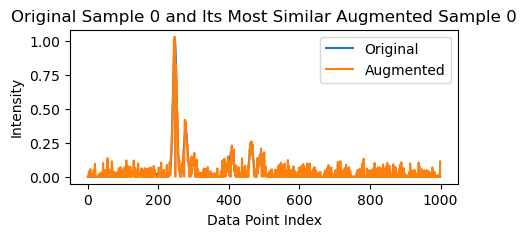

Most similar augmented data point for original sample 1 is augmented sample 1
Cosine similarity: 0.9896


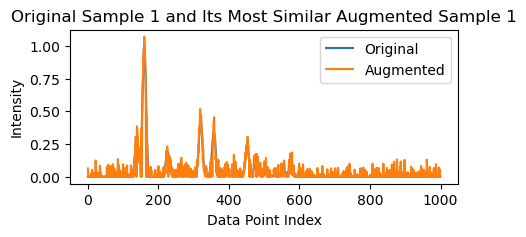

Most similar augmented data point for original sample 2 is augmented sample 2
Cosine similarity: 0.9353


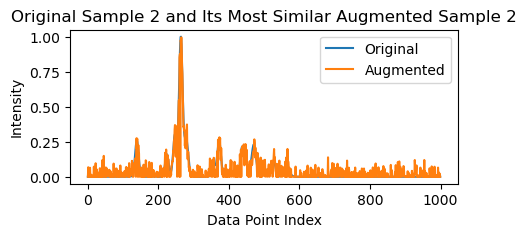

Most similar augmented data point for original sample 3 is augmented sample 3
Cosine similarity: 0.9289


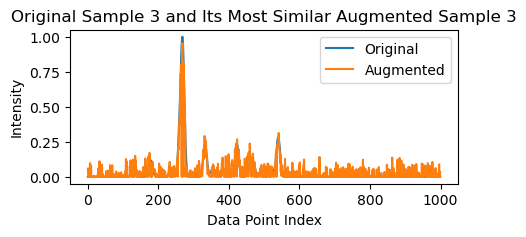

In [12]:
# Imports (same as before)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import DeciferDataset
from pytorch_metric_learning.losses import SupConLoss
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from pymatgen.symmetry.groups import SpaceGroup  # Ensure pymatgen is installed

# Updated augmentation function (as provided)
def augmentation(xrd, intensity_scale_range=(0.9, 1.1), background_scale=0.05, mask_prob=0.1):
    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask

    # Clipping
    xrd_augmented = torch.clamp(xrd_augmented, min=0.0)

    return xrd_augmented

# Model definitions (same as before)
class CLEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CLEncoder, self).__init__()
        # Encoder head
        self.enc = nn.Linear(input_dim, 128)
        
        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, data, train=True):
        if train:
            # Get two augmentations of the same batch
            augm1 = augmentation(data)
            augm2 = augmentation(data)
        
            # Extract encoder embeddings
            h_1 = self.enc(augm1)
            h_2 = self.enc(augm2)

            # Extract low dim embeddings
            h_1_latent = self.proj(h_1)
            h_2_latent = self.proj(h_2)
            return h_1, h_2, h_1_latent, h_2_latent
        else:
            # Extract encoder embeddings
            h = self.enc(data)
            return h

# Initialize models (same as before)
xrd_input_dim = 1000  # Adjust according to your data
embedding_dim = 32

xrd_encoder = CLEncoder(xrd_input_dim, embedding_dim)

# Optimizer and device (same as before)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Original Dataset
dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq", "spacegroup", "species"])

# Create a subset of the dataset
N = 1000  # Number of samples you want to use (adjust as needed)
#subset_indices = list(range(N))  # Use the first N samples
# Alternatively, select random indices
subset_indices = np.random.choice(len(dataset), N, replace=False)

subset_dataset = Subset(dataset, subset_indices)

# Extract spacegroup symbols from the subset dataset
spacegroup_symbols = set()
for idx in subset_indices:
    item = dataset[idx]
    spacegroup_symbols.add(item[1])

# Precompute the mapping from spacegroup symbols to numbers
spacegroup_symbol_to_number = {}
for symbol in spacegroup_symbols:
    try:
        sg_number = SpaceGroup(symbol).int_number
    except ValueError:
        sg_number = -1  # Assign a default or error code
    spacegroup_symbol_to_number[symbol] = sg_number

# Map spacegroup numbers to indices for labels (consecutive integers)
unique_spacegroup_numbers = sorted(set(spacegroup_symbol_to_number.values()))
if -1 in unique_spacegroup_numbers:
    unique_spacegroup_numbers.remove(-1)  # Remove the error code if present
spacegroup_number_to_idx = {sg_num: idx for idx, sg_num in enumerate(unique_spacegroup_numbers)}

# Use Supervised Contrastive Loss
loss_function = SupConLoss(temperature=0.07)

# DataLoader using the subset dataset
dataloader = DataLoader(subset_dataset, batch_size=128, shuffle=True)

# Training loop
num_epochs = 500

for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        xrd = batch[0].to(device)
        sg_labels = batch[1]  # spacegroup symbols

        # Convert symbols to numbers using the precomputed mapping
        sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

        # Handle any invalid spacegroup numbers
        valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
        if not valid_indices:
            continue  # Skip batch if all spacegroups are invalid

        xrd = xrd[valid_indices]
        sg_numbers = [sg_numbers[i] for i in valid_indices]

        # Map spacegroup numbers to indices
        sg_indices = torch.tensor([spacegroup_number_to_idx[num] for num in sg_numbers], device=device)

        optimizer.zero_grad()

        # Forward pass
        h_1, h_2, h_1_latent, h_2_latent = xrd_encoder(xrd)
        
        # Prepare embeddings and labels
        embeddings = torch.cat((h_1_latent, h_2_latent), dim=0)
        labels = torch.cat((sg_indices, sg_indices), dim=0)
        
        # Compute loss
        loss = loss_function(embeddings, labels)
        loss.backward()
        optimizer.step()

        batch_size = xrd.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualization and Similarity Analysis

# Get a sample batch
sample_batch = next(iter(dataloader))
sample = sample_batch[0].to(device)
sg_labels = sample_batch[1]  # spacegroup symbols

# Convert symbols to numbers using the precomputed mapping
sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

# Handle any invalid spacegroup numbers
valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
if not valid_indices:
    raise ValueError("No valid spacegroup numbers in sample batch for visualization.")

sample = sample[valid_indices]
sg_numbers = [sg_numbers[i] for i in valid_indices]
sg_labels = [sg_labels[i] for i in valid_indices]  # Update sg_labels

# Generate augmented samples
augmented_sample = augmentation(sample)

# Get representations
with torch.no_grad():
    h_original = xrd_encoder(sample, train=False).cpu()
    h_augmented = xrd_encoder(augmented_sample, train=False).cpu()

# Combine representations
h_combined = torch.cat([h_original, h_augmented], dim=0)

# Create labels for visualization
labels = np.array(['Original']*h_original.size(0) + ['Augmented']*h_augmented.size(0))
spacegroup_numbers_combined = sg_numbers + sg_numbers  # Duplicate for augmented samples

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(h_combined.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': h_embedded[:, 0],
    'y': h_embedded[:, 1],
    'Data Type': labels,
    'Spacegroup Number': spacegroup_numbers_combined
})

# Plot t-SNE embeddings colored by Data Type
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Data Type', style='Data Type', data=df, palette='Set1')
plt.title('t-SNE Embedding of Original and Augmented Data')
plt.legend(title='Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot t-SNE embeddings colored by Spacegroup Number
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Spacegroup Number', data=df, palette='tab20', legend='full')
plt.title('t-SNE Embedding Colored by Spacegroup Number')
# plt.legend(title='Spacegroup Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Similarity analysis
def sim_matrix(a, b, eps=1e-8):
    """
    Compute cosine similarity between two sets of embeddings
    """
    a_n = a.norm(dim=1)[:, None]
    b_n = b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

# Compute similarity between original and augmented embeddings
similarity = sim_matrix(h_original, h_augmented)

# For each original sample, find the index of the most similar augmented sample
max_indices = similarity.argmax(dim=1)
max_vals = similarity.max(dim=1).values

# Analyze individual samples
for idx in range(len(sample)):
    if idx > 3:
        break
    similar_idx = max_indices[idx]
    print(f"Most similar augmented data point for original sample {idx} is augmented sample {similar_idx}")
    print(f"Cosine similarity: {max_vals[idx]:.4f}")
    # Plot the original and most similar augmented sample
    plt.figure(figsize=(5, 2))
    plt.plot(sample[idx].cpu().numpy(), label='Original')
    plt.plot(augmented_sample[similar_idx].cpu().numpy(), label='Augmented')
    plt.legend()
    plt.title(f'Original Sample {idx} and Its Most Similar Augmented Sample {similar_idx}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Intensity')
    plt.show()

In [13]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader

# Prepare a DataLoader for evaluation
eval_batch_size = 256  # Adjust based on your memory constraints
eval_dataloader = DataLoader(subset_dataset, batch_size=eval_batch_size, shuffle=False)

# Lists to store embeddings and labels
all_embeddings = []
all_labels = []

xrd_encoder.eval()  # Set model to evaluation mode

with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc="Extracting embeddings"):
        xrd = batch[0].to(device)
        sg_labels = batch[1]  # spacegroup symbols

        # Convert symbols to numbers using the precomputed mapping
        sg_numbers = [spacegroup_symbol_to_number[sg] for sg in sg_labels]

        # Handle any invalid spacegroup numbers
        valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
        if not valid_indices:
            continue  # Skip batch if all spacegroups are invalid

        xrd = xrd[valid_indices]
        sg_numbers = [sg_numbers[i] for i in valid_indices]

        # Get embeddings
        embeddings = xrd_encoder(xrd, train=False).cpu().numpy()
        all_embeddings.append(embeddings)
        all_labels.extend(sg_numbers)

# Concatenate all embeddings and labels
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.array(all_labels)


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
# Compute the Silhouette Score
sil_score = silhouette_score(all_embeddings, all_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: -0.2296


In [15]:
from sklearn.cluster import KMeans

# Number of clusters is the number of unique spacegroup numbers
n_clusters = len(np.unique(all_labels))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

# Compute ARI
ari = adjusted_rand_score(all_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")


Adjusted Rand Index: 0.0434


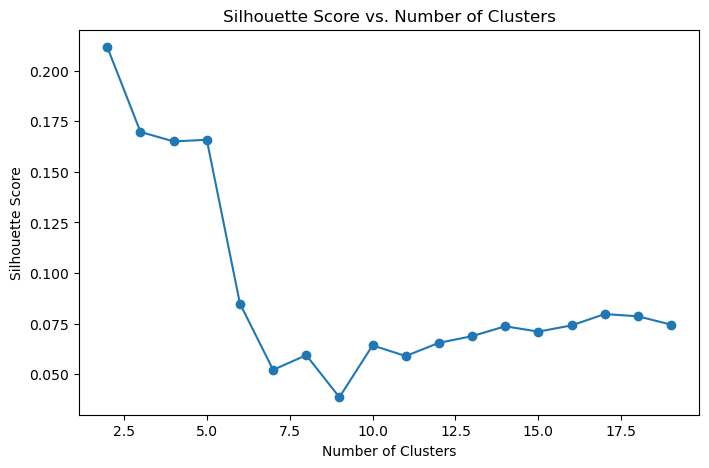

In [18]:
import matplotlib.pyplot as plt

sil_scores = []
cluster_range = range(2, 20)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_embeddings)
    sil_score = silhouette_score(all_embeddings, cluster_labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


# Unsupervised Contrastive Learning on a Subset

In [8]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import DeciferDataset
from pytorch_metric_learning.losses import NTXentLoss
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd

# Define the augmentation function (as provided)
def augmentation(xrd, intensity_scale_range=(0.9, 1.1), background_scale=0.05, mask_prob=0.1):
    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask

    # Clipping
    xrd_augmented = torch.clamp(xrd_augmented, min=0.0)

    return xrd_augmented

# Model definitions
class CLEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CLEncoder, self).__init__()
        # Encoder head
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512)
        )
        
        # Projection head
        self.proj = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, embedding_dim)
        )

    def forward(self, data, train=True):
        if train:
            # Get two augmentations of the same batch
            augm1 = augmentation(data)
            augm2 = augmentation(data)
        
            # Extract encoder embeddings
            h_1 = self.enc(augm1)
            h_2 = self.enc(augm2)

            # Extract low-dimensional embeddings
            h_1_latent = self.proj(h_1)
            h_2_latent = self.proj(h_2)
            return h_1, h_2, h_1_latent, h_2_latent
        else:
            # Extract encoder embeddings
            h = self.enc(data)
            h_latent = self.proj(h)
            return h, h_latent

# Initialize model parameters
xrd_input_dim = 1000  # Adjust according to your data
embedding_dim = 512  # Higher dimension can capture more information

# Initialize the encoder model
xrd_encoder = CLEncoder(xrd_input_dim, embedding_dim)

# Optimizer and device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Original Dataset
dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq"])

# Create a subset of the dataset
N = 5000  # Number of samples you want to use (adjust as needed)
# subset_indices = list(range(N))  # Use the first N samples
# Alternatively, select random indices
subset_indices = np.random.choice(len(dataset), N, replace=False)

subset_dataset = Subset(dataset, subset_indices)

# DataLoader using the subset dataset
dataloader = DataLoader(subset_dataset, batch_size=128, shuffle=True)

# Use NTXentLoss (unsupervised contrastive loss)
loss_function = NTXentLoss(temperature=0.07)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        xrd = batch[0].to(device)

        optimizer.zero_grad()

        # Forward pass
        _, _, z_i, z_j = xrd_encoder(xrd)

        # Normalize embeddings
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)

        # Prepare embeddings and labels
        embeddings = torch.cat([z_i, z_j], dim=0)
        labels = torch.arange(xrd.size(0)).repeat(2).to(device)

        # Compute loss
        loss = loss_function(embeddings, labels)
        loss.backward()
        optimizer.step()

        batch_size = xrd.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch 1/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0768


In [11]:
# Evaluation and Visualization
# Since we didn't use labels during training, we'll use them now for evaluation

# Import labels for evaluation (e.g., spacegroup numbers)
# For evaluation purposes only, not used during training
from pymatgen.symmetry.groups import SpaceGroup  # Ensure pymatgen is installed

# Update the subset dataset to include labels for evaluation
dataset_with_labels = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq", "spacegroup", "species"])

subset_dataset_with_labels = Subset(dataset_with_labels, subset_indices)

# Prepare a DataLoader for evaluation
eval_batch_size = 64  # Adjust based on your memory constraints
eval_dataloader = DataLoader(subset_dataset_with_labels, batch_size=eval_batch_size, shuffle=False)

# Lists to store embeddings and labels
debug_max = 100
all_embeddings = []
all_labels = []
all_species = []

xrd_encoder.eval()  # Set model to evaluation mode
pbar = tqdm(total=min(debug_max+1, len(eval_dataloader)), desc="Extracting embeddings")
with torch.no_grad():
    for i, batch in enumerate(eval_dataloader):
        if i*batch_size > debug_max:
            break
        xrd = batch[0].to(device)
        sg_labels = batch[1]  # spacegroup symbols

        # Convert symbols to numbers using pymatgen
        sg_numbers = []
        for j, sg in enumerate(sg_labels):
            try:
                sg_number = SpaceGroup(sg).int_number
                species = batch[2][j] # Species symbols
                all_species.append(species)
            except ValueError:
                sg_number = -1  # Assign a default or error code
                all_species.append([' '])
            sg_numbers.append(sg_number)

        # Handle any invalid spacegroup numbers
        valid_indices = [i for i, num in enumerate(sg_numbers) if num != -1]
        if not valid_indices:
            continue  # Skip batch if all spacegroups are invalid

        xrd = xrd[valid_indices]
        sg_numbers = [sg_numbers[i] for i in valid_indices]

        # Get embeddings
        embeddings = xrd_encoder(xrd, train=False)[1].cpu().numpy()
        all_embeddings.append(embeddings)
        all_labels.extend(sg_numbers)
        
        pbar.update(batch_size)
        
pbar.close()

# Concatenate all embeddings and labels
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.array(all_labels)


Extracting embeddings:   0%|          | 0/79 [00:00<?, ?it/s]

Silhouette Score: -0.2354
Adjusted Rand Index: 0.0157
Normalized Mutual Information: 0.3131


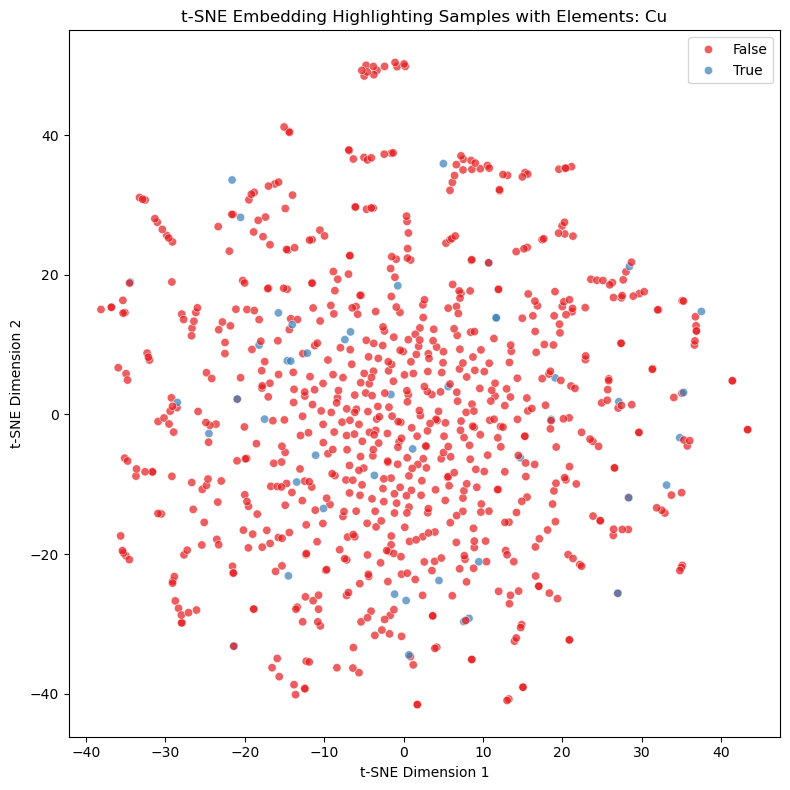

In [12]:
# Visualization with Spacegroup Number as a Colormap and Species Labels
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import numpy as np
import ast

# Compute the Silhouette Score
sil_score = silhouette_score(all_embeddings, all_labels)
print(f"Silhouette Score: {sil_score:.4f}")

# -----

# Number of clusters is the number of unique spacegroup numbers
n_clusters = len(np.unique(all_labels))

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)

# Compute ARI
ari = adjusted_rand_score(all_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

# Compute NMI
nmi = normalized_mutual_info_score(all_labels, cluster_labels)
print(f"Normalized Mutual Information: {nmi:.4f}")

# -----

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)


# Parse the species strings and collect all unique elements
all_elements = set()
species_lists = []
for s in all_species:
    elements = ast.literal_eval(s)  # Convert string to list
    species_lists.append(elements)
    all_elements.update(elements)

# Map elements to indices
element_to_index = {element: idx for idx, element in enumerate(sorted(all_elements))}


# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Spacegroup Number': all_labels,
    'Species': [' '.join(elements) for elements in species_lists]  # Join species for labeling
})


# Plot with colormap for Spacegroup Numbers
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=df['x'],
    y=df['y'],
    c=df['Spacegroup Number'],
    cmap='viridis',  # Choose a colormap
    alpha=0.7
)
plt.title('t-SNE Embedding Colored by Spacegroup Number with Species Labels')
cbar = plt.colorbar(scatter)
cbar.set_label('Spacegroup Number')


plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()


num_samples = len(species_lists)
num_elements = len(all_elements)
element_presence = np.zeros((num_samples, num_elements), dtype=int)

for i, elements in enumerate(species_lists):
    for element in elements:
        idx = element_to_index[element]
        element_presence[i, idx] = 1

# Define the combination of elements to look for
elements_of_interest = ['Cu']  # Replace with the list of elements you are interested in

# Create a boolean mask for samples that contain all elements in elements_of_interest
def has_all_elements(sample_elements, target_elements):
    return set(target_elements).issubset(set(sample_elements))

mask = [has_all_elements(elements, elements_of_interest) for elements in species_lists]

# Add the mask to the DataFrame
df['Has Elements'] = mask

# Plot t-SNE embeddings, highlighting samples with the specific combination of elements
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='x', y='y',
    hue='Has Elements',
    data=df,
    palette='Set1',
    alpha=0.7
)
plt.title(f't-SNE Embedding Highlighting Samples with Elements: {", ".join(elements_of_interest)}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()


### Extract All Unique Elements
First, parse the species data to extract the elements present in each structure and collect all unique elements.

In [161]:
import ast

# Assuming 'species' is a list where each item is a string representation of a list, e.g., '["Be", "K", "Ti"]'

# # Extract species from the valid samples (same as embeddings and labels)
# species = []
# valid_labels = []
# for i, item in tqdm(enumerate(subset_dataset_with_labels), total=min((debug_max+1) * eval_batch_size, len(subset_dataset_with_labels))):
#     if i > debug_max * eval_batch_size:
#         break
#     try:
#         sg_number = SpaceGroup(item[1]).int_number
#         species.append(item[2])  # Species extraction
#         valid_labels.append(sg_number)
#     except ValueError:
#         continue

# Parse the species strings and collect all unique elements
all_elements = set()
species_lists = []
for s in all_species:
    elements = ast.literal_eval(s)  # Convert string to list
    species_lists.append(elements)
    all_elements.update(elements)

# Map elements to indices
element_to_index = {element: idx for idx, element in enumerate(sorted(all_elements))}


### Create a Binary Indicator Matrix
Create a binary matrix where each row corresponds to a data point, and each column corresponds to an element. A value of 1 indicates the presence of the element in that structure.

In [150]:
import numpy as np

num_samples = len(species_lists)
num_elements = len(all_elements)
element_presence = np.zeros((num_samples, num_elements), dtype=int)

for i, elements in tqdm(enumerate(species_lists), total=len(species_lists)):
    for element in elements:
        idx = element_to_index[element]
        element_presence[i, idx] = 1


  0%|          | 0/224 [00:00<?, ?it/s]

### Visualize Element Presence on t-SNE Plot
Now, select an element of interest and use its presence vector to color the t-SNE plot.

In [158]:
len(all_labels)

224

In [152]:
len([' '.join(elements) for elements in species_lists])

224

In [153]:
len(embeddings_2d[:, 0])

224

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce embeddings to 2D using t-SNE (assuming you have 'all_embeddings' from before)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Spacegroup Number': all_labels,
    'Species': [' '.join(elements) for elements in species_lists]  # Join species for labeling
})


### Visualizing Multiple Elements
You can create multiple plots for different elements or even create subplots to compare the distribution of various elements.

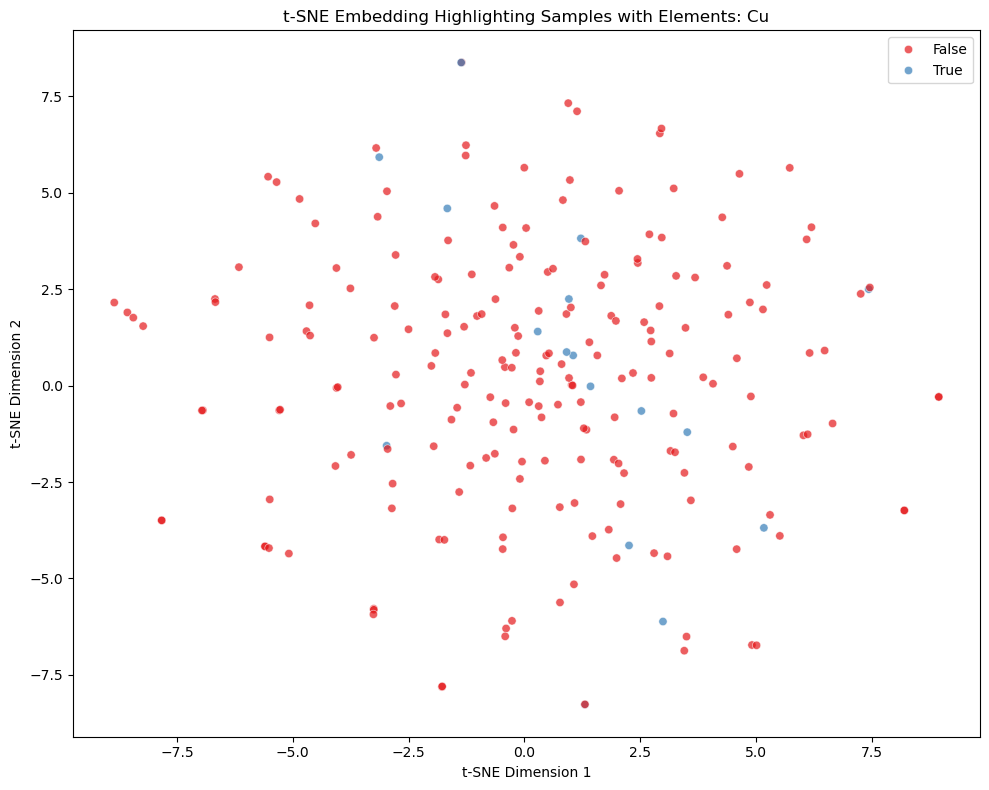

In [157]:
# Visualization of Embeddings Highlighting Samples with a Specific Combination of Elements

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming you have:
# - all_embeddings: numpy array of shape (num_samples, embedding_dim)
# - species_lists: list of lists, where each inner list contains the elements present in that sample

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': embeddings_2d[:, 0][:1601],
    'y': embeddings_2d[:, 1][:1601],
    'Species': [' '.join(elements) for elements in species_lists][:1601]  # Join species for labeling
})

# Define the combination of elements to look for
elements_of_interest = ['Cu']  # Replace with the list of elements you are interested in

# Create a boolean mask for samples that contain all elements in elements_of_interest
def has_all_elements(sample_elements, target_elements):
    return set(target_elements).issubset(set(sample_elements))

mask = [has_all_elements(elements, elements_of_interest) for elements in species_lists]

# Add the mask to the DataFrame
df['Has Elements'] = mask

# Plot t-SNE embeddings, highlighting samples with the specific combination of elements
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y',
    hue='Has Elements',
    data=df,
    palette='Set1',
    alpha=0.7
)
plt.title(f't-SNE Embedding Highlighting Samples with Elements: {", ".join(elements_of_interest)}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()#title='Has Elements', labels=['No', 'Yes'], loc='best')
plt.tight_layout()
plt.show()


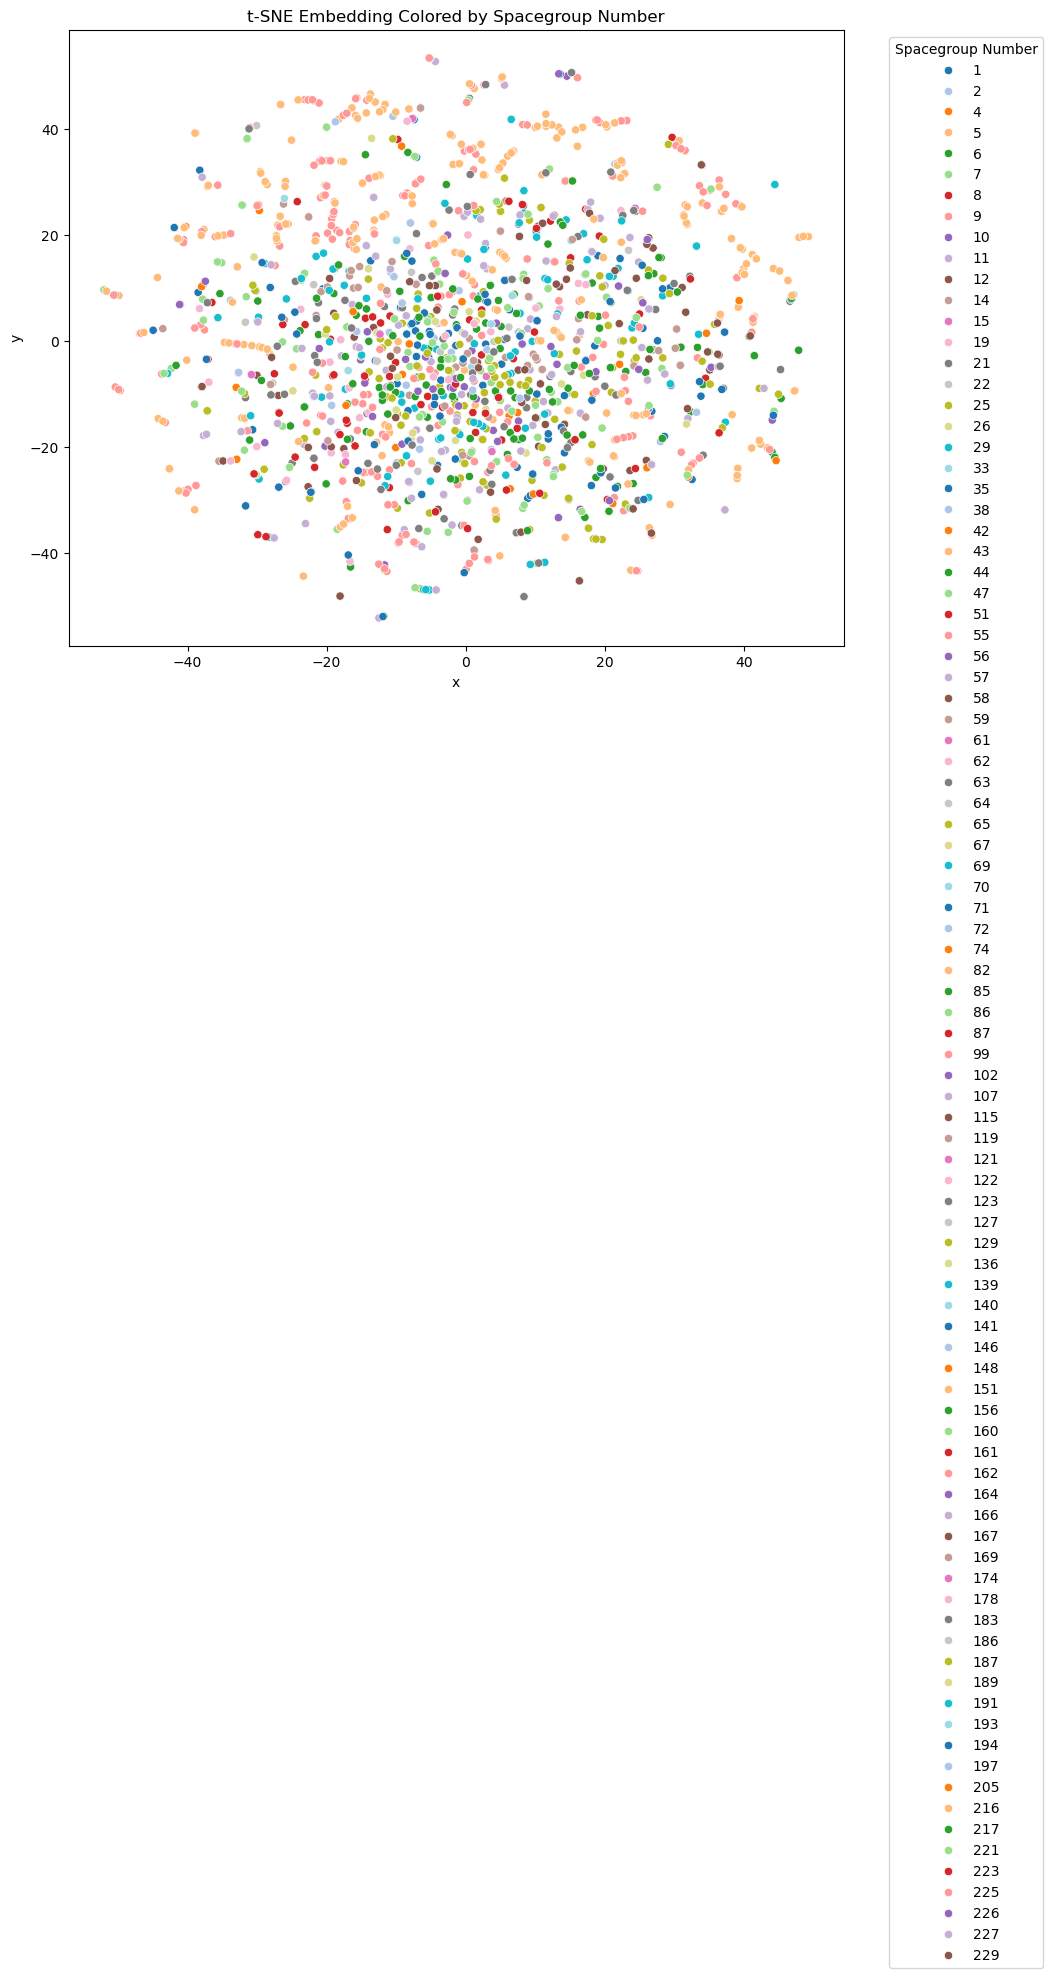

In [80]:
from sklearn.manifold import TSNE

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Spacegroup Number': all_labels
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Spacegroup Number', data=df, palette='tab20', legend='full')
plt.title('t-SNE Embedding Colored by Spacegroup Number')
plt.legend(title='Spacegroup Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Direct embedding of SOAP

In [13]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from decifer import DeciferDataset
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd

# Define the updated augmentation function
def augmentation(xrd, intensity_scale_range=(0.9, 1.1), background_scale=0.05, mask_prob=0.1):
    """
    Applies augmentation to XRD data by randomly scaling intensities,
    adding background noise, masking, and clipping negative values.
    """
    # Random scaling of intensities
    intensity_scale = torch.empty((xrd.size(0), 1), device=xrd.device).uniform_(*intensity_scale_range)
    xrd_scaled = xrd * intensity_scale

    # Random background addition
    background = torch.randn_like(xrd) * background_scale
    xrd_augmented = xrd_scaled + background

    # Random masking
    mask = torch.rand_like(xrd_augmented) > mask_prob
    xrd_augmented = xrd_augmented * mask

    # Clipping negative values
    xrd_augmented = torch.clamp(xrd_augmented, min=0.0)

    return xrd_augmented

# Define the model
class XRDEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        """
        Neural network model that encodes XRD data into embeddings
        aligned with SOAP descriptors.
        """
        super(XRDEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Dataset and DataLoader with "xrd_cont.iq" and "soap"
dataset = DeciferDataset("../data/crystallm/full/serialized/test.h5", ["xrd_cont.iq", "soap"])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get a sample batch to determine dimensions
sample_batch = next(iter(dataloader))
xrd_sample = sample_batch[0]
soap_sample = sample_batch[1]

xrd_input_dim = xrd_sample.shape[1]
soap_dim = soap_sample.shape[1]

# Initialize model
xrd_encoder = XRDEncoder(xrd_input_dim, soap_dim)

# Optimizer and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xrd_encoder.to(device)
optimizer = optim.Adam(xrd_encoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    xrd_encoder.train()
    total_loss = 0.0
    total_samples = 0
    
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        xrd = batch[0].to(device)  # XRD data
        soap = batch[1].to(device)  # SOAP descriptors

        # Apply augmentation
        xrd_augmented = augmentation(xrd)

        # Forward pass
        embeddings = xrd_encoder(xrd_augmented)

        # Compute loss
        loss = criterion(embeddings, soap)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = xrd.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Visualization
# Get a sample batch for visualization
sample_batch = next(iter(dataloader))
xrd_sample = sample_batch[0].to(device)
soap_sample = sample_batch[1].to(device)

# Generate augmented samples
xrd_augmented_sample = augmentation(xrd_sample)

# Get embeddings
xrd_encoder.eval()
with torch.no_grad():
    embeddings_original = xrd_encoder(xrd_sample).cpu()
    embeddings_augmented = xrd_encoder(xrd_augmented_sample).cpu()
    soap_sample_cpu = soap_sample.cpu()

# Combine embeddings
embeddings_combined = torch.cat([embeddings_original, embeddings_augmented, soap_sample_cpu], dim=0)
labels = ['Original']*embeddings_original.shape[0] + ['Augmented']*embeddings_augmented.shape[0] + ['SOAP']*soap_sample_cpu.shape[0]

# Perform t-SNE for visualization
h_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings_combined.numpy())

# Create a DataFrame for plotting
df = pd.DataFrame({
    'x': h_embedded[:, 0],
    'y': h_embedded[:, 1],
    'Type': labels
})

# Plot the embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='Type', data=df, palette='Set1')
plt.title('t-SNE Embedding of Original, Augmented, and SOAP Data')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KeyError: "Unable to synchronously open object (object 'soap' doesn't exist)"